In [1]:
# MC Control, SARSA, Q-Learning, Double Q-learning

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk, gym_aima
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [5]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [7]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [8]:
def get_policy_metrics(env, gamma, pi, goal_state, optimal_Q, 
                       n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    reached_goal, episode_reward, episode_regret = [], [], []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        episode_reward.append(0.0)
        episode_regret.append(0.0)
        while not done and steps < max_steps:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            episode_regret[-1] += regret
            
            state, reward, done, _ = env.step(action)
            episode_reward[-1] += (gamma**steps * reward)
            
            steps += 1

        reached_goal.append(state == goal_state)
    results = np.array((np.sum(reached_goal)/len(reached_goal)*100, 
                        np.mean(episode_reward), 
                        np.mean(episode_regret)))
    return results

In [9]:
def get_metrics_from_tracks(env, gamma, goal_state, optimal_Q, pi_track, coverage=0.1):
    total_samples = len(pi_track)
    n_samples = int(total_samples * coverage)
    samples_e = np.linspace(0, total_samples, n_samples, endpoint=True, dtype=np.int)
    metrics = []
    for e, pi in enumerate(tqdm(pi_track)):
        if e in samples_e:
            metrics.append(get_policy_metrics(
                env, 
                gamma=gamma, 
                pi=lambda s: pi[s], 
                goal_state=goal_state, 
                optimal_Q=optimal_Q))
        else:
            metrics.append(metrics[-1])
    metrics = np.array(metrics)
    success_rate_ma, mean_return_ma, mean_regret_ma = np.apply_along_axis(moving_average, axis=0, arr=metrics).T
    return success_rate_ma, mean_return_ma, mean_regret_ma 

In [10]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [11]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [12]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(len(valid_values), limit_items), 
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v*({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [13]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

# Slippery Walk Seven

In [14]:
env = gym.make('SlipperyWalkSeven-v0')
init_state = env.reset()
goal_state = 8
gamma = 0.99
n_episodes = 3000
P = env.env.P
n_cols, svf_prec, err_prec, avf_prec=9, 4, 2, 3
action_symbols=('<', '>')
limit_items, limit_value = 5, 0.0
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.0, 100

## Alpha and Epsilon schedules

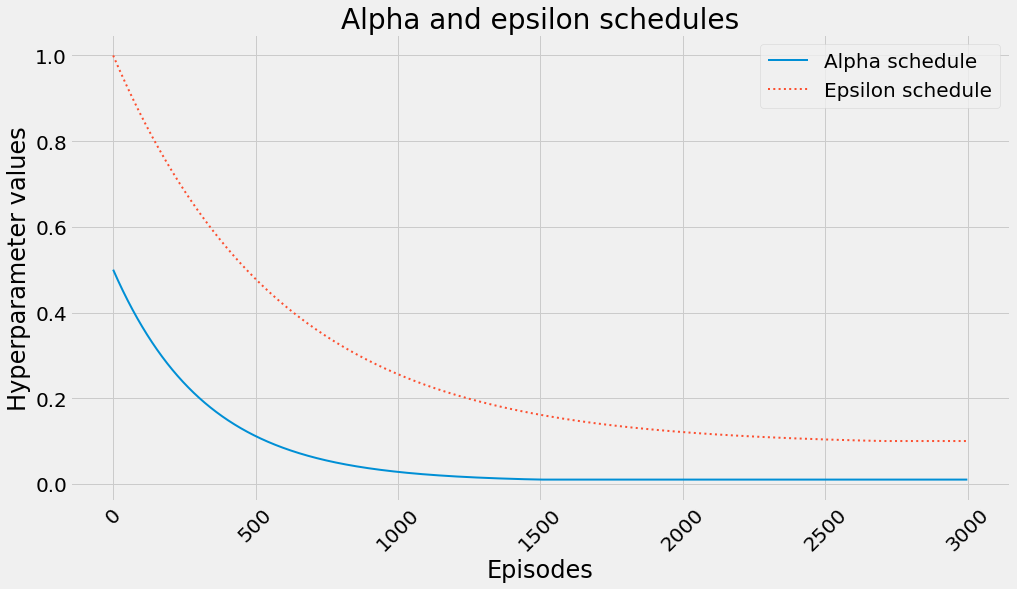

In [15]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes), 
         '-', linewidth=2, 
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes), 
         ':', linewidth=2, 
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

## Optimal value functions and policy

In [16]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |

Optimal action-value function:
╒═════╤═══════╤═══════╕
│   s │     < │     > │
╞═════╪═══════╪═══════╡
│   0 │ 0     │ 0     │
├─────┼───────┼───────┤
│   1 │ 0.312 │ 0.564 │
├─────┼───────┼───────┤
│   2 │ 0.67  │ 0.763 │
├─────┼───────┼───────┤
│   3 │ 0.803 │ 0.845 │
├─────┼───────┼───────┤
│   4 │ 0.864 │ 0.889 │
├─────┼───────┼───────┤
│   5 │ 0.901 │ 0.922 │
├─────┼───────┼───────┤
│   6 │ 0.932 │ 0.952 │
├─────┼───────┼───────┤
│   7 │ 0.961 │ 0.981 │
├─────┼───────┼───────┤
│   8 │ 0     │ 0     │
╘═════╧═══════╧═══════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 96.00%. Obtains an average return of 0.8548. Regret of 0.0000


# First-visit Monte-Carlo Control

In [17]:
def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, np.object)

In [18]:
def mc_control(env,
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000,
               max_steps=200,
               first_visit=True):
    nS, nA = env.observation_space.n, env.action_space.n
    discounts = np.logspace(0, 
                            max_steps, 
                            num=max_steps, 
                            base=gamma, 
                            endpoint=False) 
    alphas = decay_schedule(init_alpha, 
                           min_alpha, 
                           alpha_decay_ratio, 
                           n_episodes)
    epsilons = decay_schedule(init_epsilon, 
                              min_epsilon, 
                              epsilon_decay_ratio, 
                              n_episodes)
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))

    for e in tqdm(range(n_episodes), leave=False):
        
        trajectory = generate_trajectory(select_action,
                                         Q,
                                         epsilons[e],
                                         env, 
                                         max_steps)
        visited = np.zeros((nS, nA), dtype=np.bool)
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            if visited[state][action] and first_visit:
                continue
            visited[state][action] = True
            
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [19]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs ; del V_mcs ; del Q_track_mcs

In [20]:
print_state_value_function(V_mc, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

State-value function found by FVMC:
|           | 01 0.4895 | 02 0.7209 | 03 0.8311 | 04 0.8766 | 05 0.9137 | 06 0.9463 | 07 0.9788 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.07 | 02  -0.04 | 03  -0.01 | 04  -0.01 | 05  -0.01 | 06  -0.01 | 07   -0.0 |           |
State-value function RMSE: 0.0293

FVMC action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.194 │ 0.489 │ 0.312 │ 0.564 │   0.118 │   0.074 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.549 │ 0.721 │ 0.67  │ 0.763 │   0.121 │   0.042 │
├─────┼───────┼───────┼───────┼─

# SARSA

In [21]:
def sarsa(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.5,
          init_epsilon=1.0,
          min_epsilon=0.1,
          epsilon_decay_ratio=0.9,
          n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha, 
                           min_alpha, 
                           alpha_decay_ratio, 
                           n_episodes)
    epsilons = decay_schedule(init_epsilon, 
                              min_epsilon, 
                              epsilon_decay_ratio, 
                              n_episodes)
    
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            state, action = next_state, next_action
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [22]:
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=gamma, n_episodes=n_episodes)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)
del Q_sarsas ; del V_sarsas ; del Q_track_sarsas

In [23]:
print_state_value_function(V_sarsa, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa = get_policy_metrics(
    env, gamma=gamma, pi=pi_sarsa, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa))

State-value function found by SARSA:
|           | 01  0.461 | 02 0.6868 | 03  0.797 | 04  0.863 | 05 0.9075 | 06 0.9461 | 07 0.9767 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01   -0.1 | 02  -0.08 | 03  -0.05 | 04  -0.03 | 05  -0.01 | 06  -0.01 | 07   -0.0 |           |
State-value function RMSE: 0.0467

SARSA action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.163 │ 0.461 │ 0.312 │ 0.564 │   0.149 │   0.103 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.5   │ 0.687 │ 0.67  │ 0.763 │   0.17  │   0.076 │
├─────┼───────┼───────┼───────

# Q-Learning

In [24]:
def q_learning(env, 
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha, 
                           min_alpha, 
                           alpha_decay_ratio, 
                           n_episodes)
    epsilons = decay_schedule(init_epsilon, 
                              min_epsilon, 
                              epsilon_decay_ratio, 
                              n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            state = next_state

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [25]:
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)
del Q_qls ; del V_qls ; del Q_track_qls

In [26]:
print_state_value_function(V_ql, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_ql, mean_return_ql, mean_regret_ql = get_policy_metrics(
    env, gamma=gamma, pi=pi_ql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ql, mean_return_ql, mean_regret_ql))

State-value function found by Q-learning:
|           | 01 0.5523 | 02  0.754 | 03 0.8432 | 04 0.8893 | 05 0.9215 | 06 0.9509 | 07   0.98 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.01 | 02  -0.01 | 03   -0.0 | 04    0.0 | 05   -0.0 | 06   -0.0 | 07   -0.0 |           |
State-value function RMSE: 0.0049

Q-learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.303 │ 0.552 │ 0.312 │ 0.564 │   0.009 │   0.011 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.659 │ 0.754 │ 0.67  │ 0.763 │   0.011 │   0.009 │
├─────┼───────┼─────

# Double Q-Learning

In [27]:
def double_q_learning(env,
                      gamma=1.0,
                      init_alpha=0.5,
                      min_alpha=0.01,
                      alpha_decay_ratio=0.5,
                      init_epsilon=1.0,
                      min_epsilon=0.1,
                      epsilon_decay_ratio=0.9,
                      n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q1 = np.zeros((nS, nA), dtype=np.float64)
    Q2 = np.zeros((nS, nA), dtype=np.float64)
    Q_track1 = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    Q_track2 = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha, 
                           min_alpha, 
                           alpha_decay_ratio, 
                           n_episodes)
    epsilons = decay_schedule(init_epsilon, 
                              min_epsilon, 
                              epsilon_decay_ratio, 
                              n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        while not done:
            action = select_action(state, (Q1 + Q2)/2, epsilons[e])
            next_state, reward, done, _ = env.step(action)

            if np.random.randint(2):
                argmax_Q1 = np.argmax(Q1[next_state])
                td_target = reward + gamma * Q2[next_state][argmax_Q1] * (not done)
                td_error = td_target - Q1[state][action]
                Q1[state][action] = Q1[state][action] + alphas[e] * td_error
            else:
                argmax_Q2 = np.argmax(Q2[next_state])
                td_target = reward + gamma * Q1[next_state][argmax_Q2] * (not done)
                td_error = td_target - Q2[state][action]
                Q2[state][action] = Q2[state][action] + alphas[e] * td_error
            state = next_state

        Q_track1[e] = Q1
        Q_track2[e] = Q2        
        pi_track.append(np.argmax((Q1 + Q2)/2, axis=1))

    Q = (Q1 + Q2)/2.
    V = np.max(Q, axis=1)    
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, (Q_track1 + Q_track2)/2., pi_track

In [28]:
Q_dqls, V_dqls, Q_track_dqls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_dqls.append(Q_dql) ; V_dqls.append(V_dql) ; Q_track_dqls.append(Q_track_dql)
Q_dql, V_dql, Q_track_dql = np.mean(Q_dqls, axis=0), np.mean(V_dqls, axis=0), np.mean(Q_track_dqls, axis=0)
del Q_dqls ; del V_dqls ; del Q_track_dqls

In [29]:
print_state_value_function(V_dql, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_dql, mean_return_dql, mean_regret_dql = get_policy_metrics(
    env, gamma=gamma, pi=pi_dql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dql, mean_return_dql, mean_regret_dql))

State-value function found by Double Q-Learning:
|           | 01  0.576 | 02 0.7688 | 03 0.8467 | 04 0.8896 | 05 0.9221 | 06 0.9515 | 07 0.9804 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01   0.01 | 02   0.01 | 03    0.0 | 04    0.0 | 05    0.0 | 06   -0.0 | 07   -0.0 |           |
State-value function RMSE: 0.0046

Double Q-Learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.292 │ 0.576 │ 0.312 │ 0.564 │   0.02  │  -0.012 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.692 │ 0.769 │ 0.67  │ 0.763 │  -0.021 │  -0.006 │
├─────

# Comparison of max(Q) for every episode

## First-visit Monte-Carlo

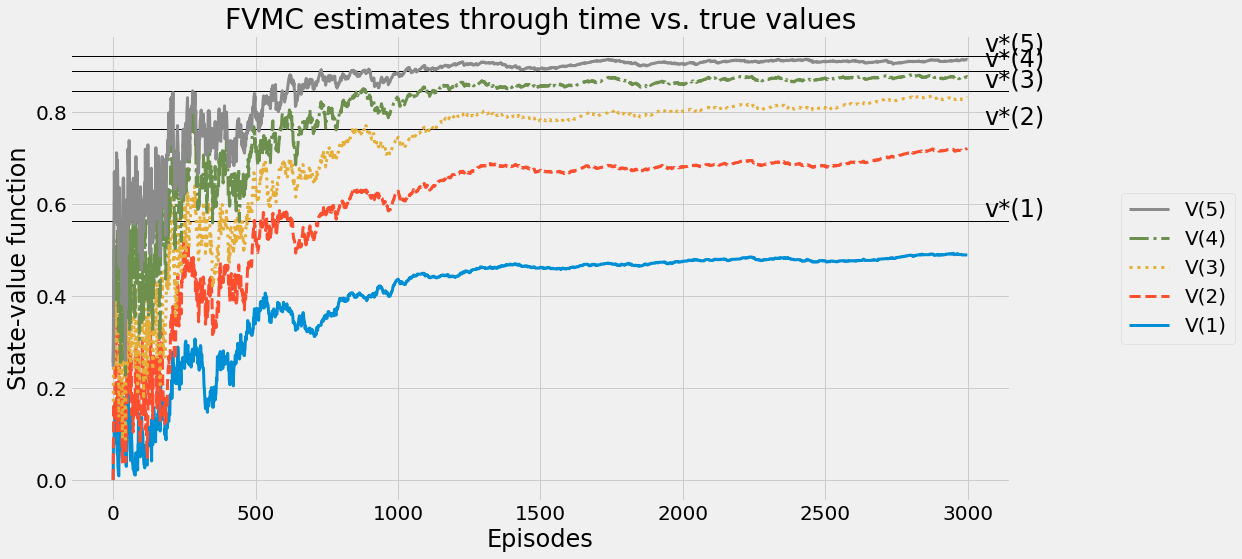

In [30]:
plot_value_function(
    'FVMC estimates through time vs. true values', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

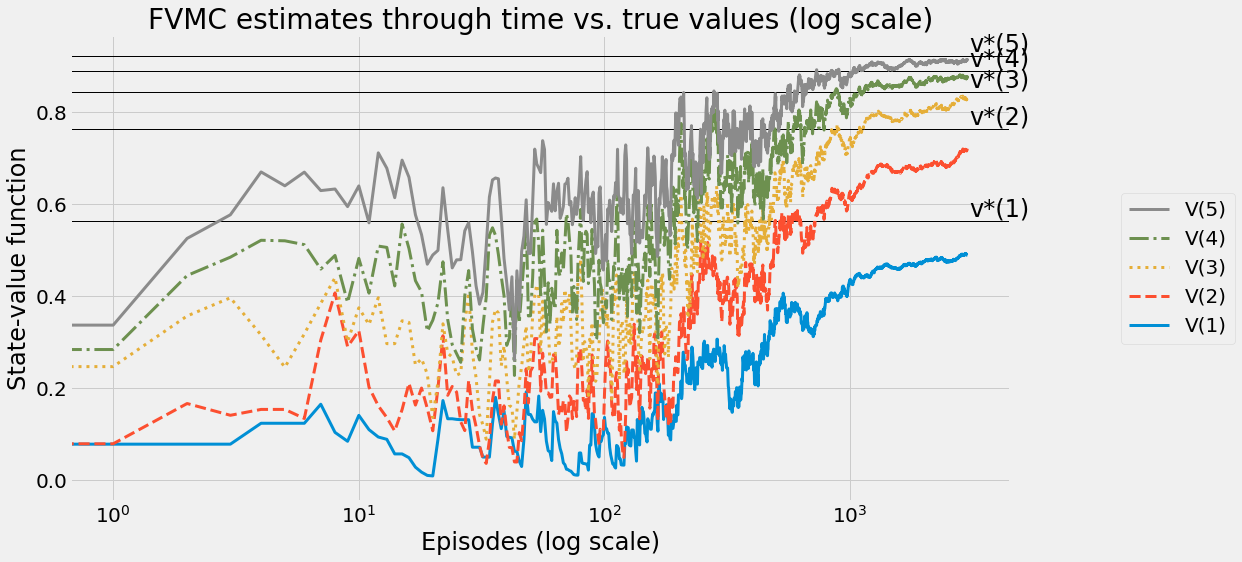

In [31]:
plot_value_function(
    'FVMC estimates through time vs. true values (log scale)', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

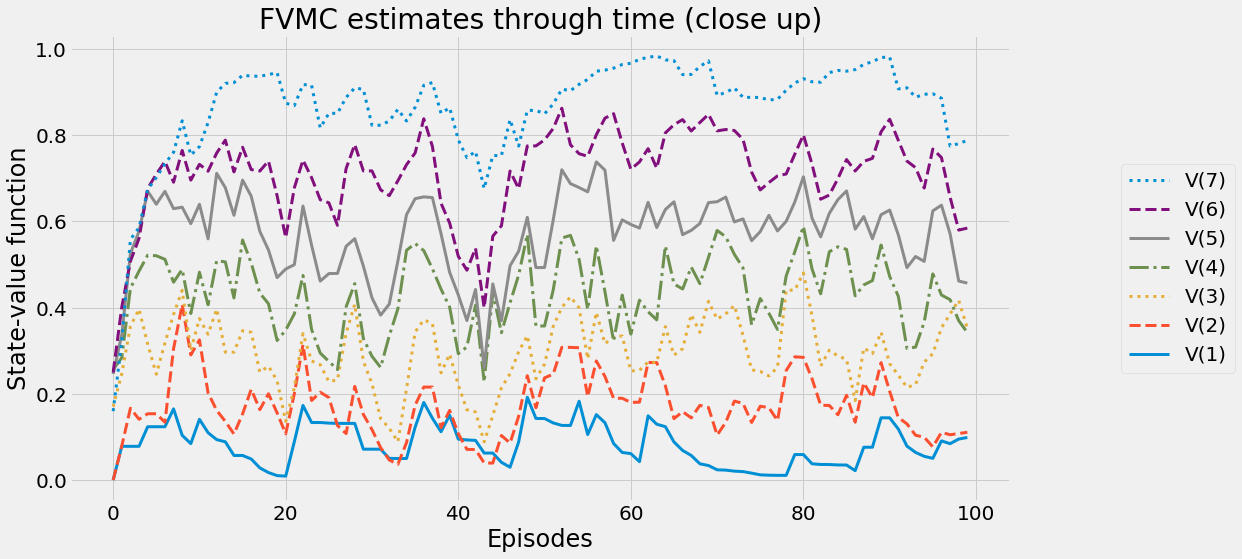

In [32]:
plot_value_function(
    'FVMC estimates through time (close up)', 
    np.max(Q_track_mc, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

## SARSA

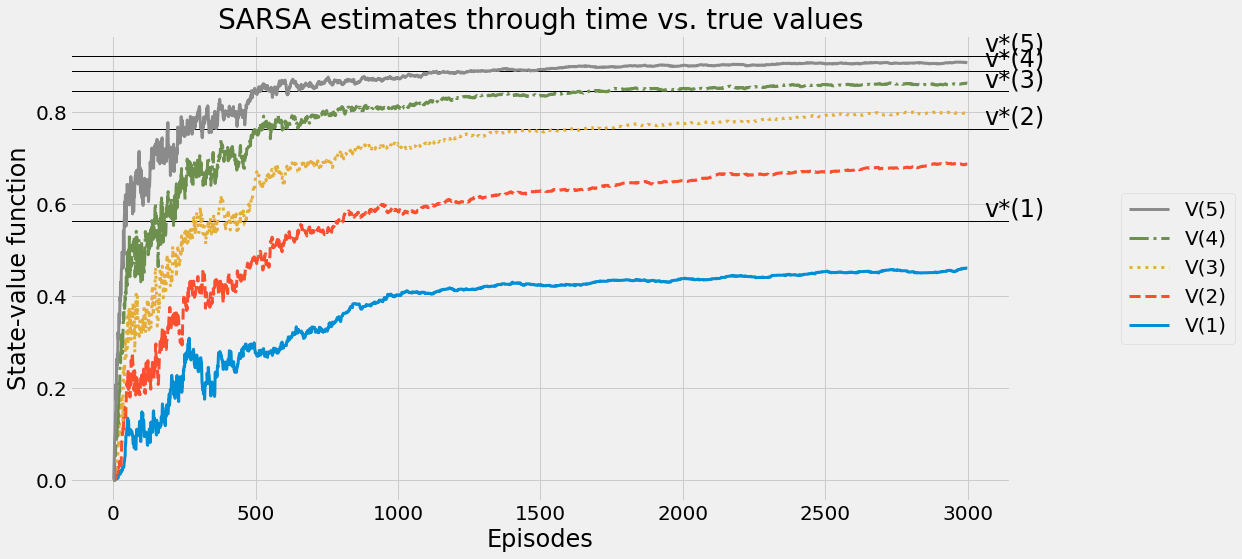

In [33]:
plot_value_function(
    'SARSA estimates through time vs. true values', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

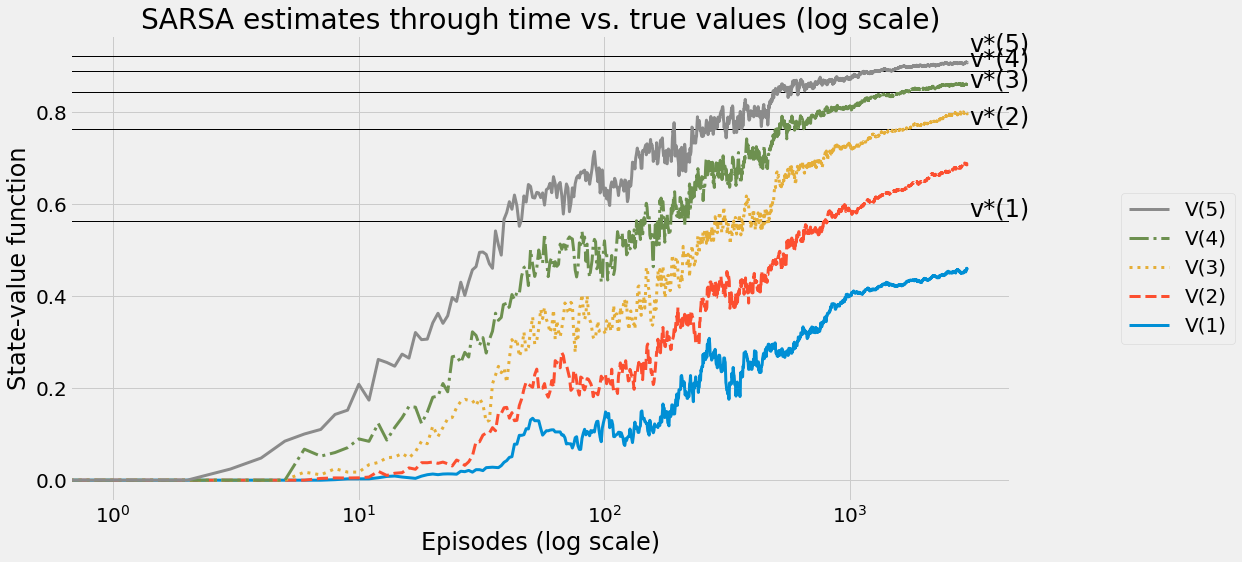

In [34]:
plot_value_function(
    'SARSA estimates through time vs. true values (log scale)', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

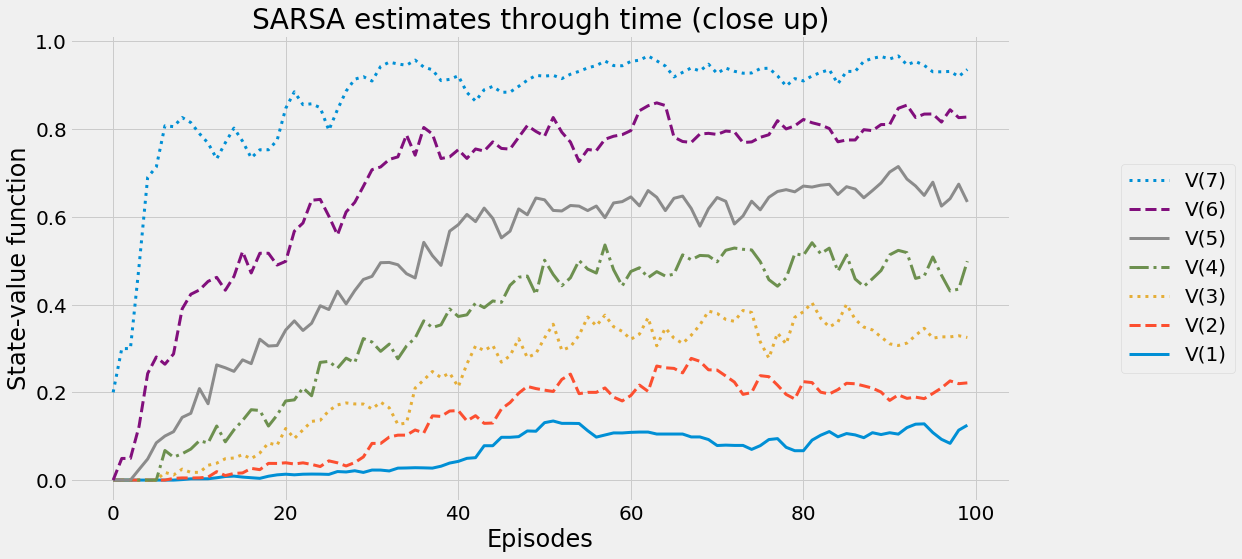

In [35]:
plot_value_function(
    'SARSA estimates through time (close up)', 
    np.max(Q_track_sarsa, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

## Q-learning

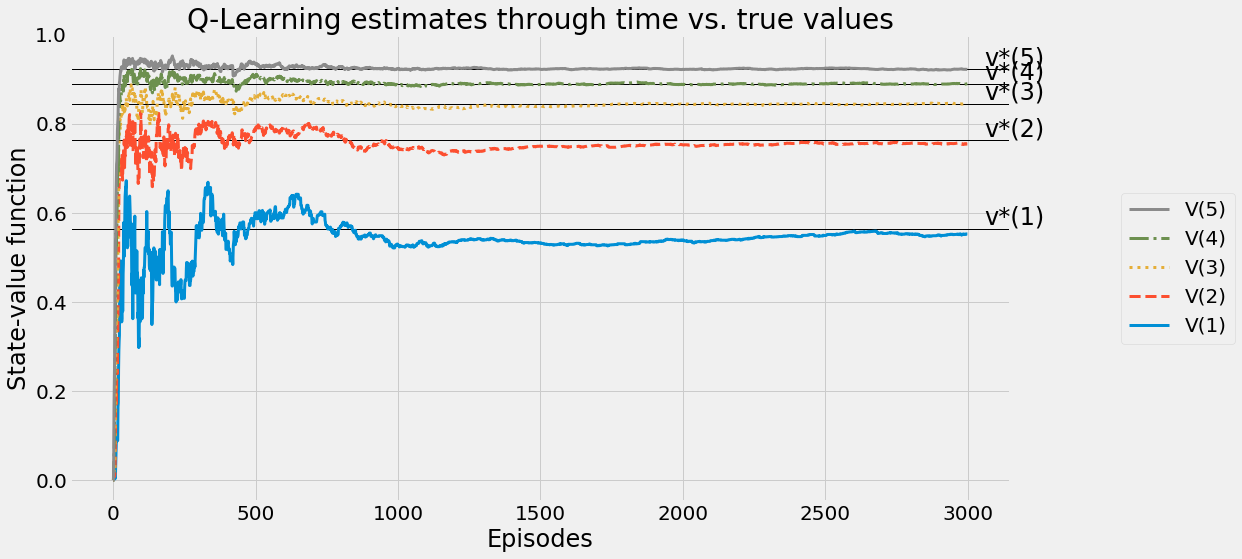

In [36]:
plot_value_function(
    'Q-Learning estimates through time vs. true values', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

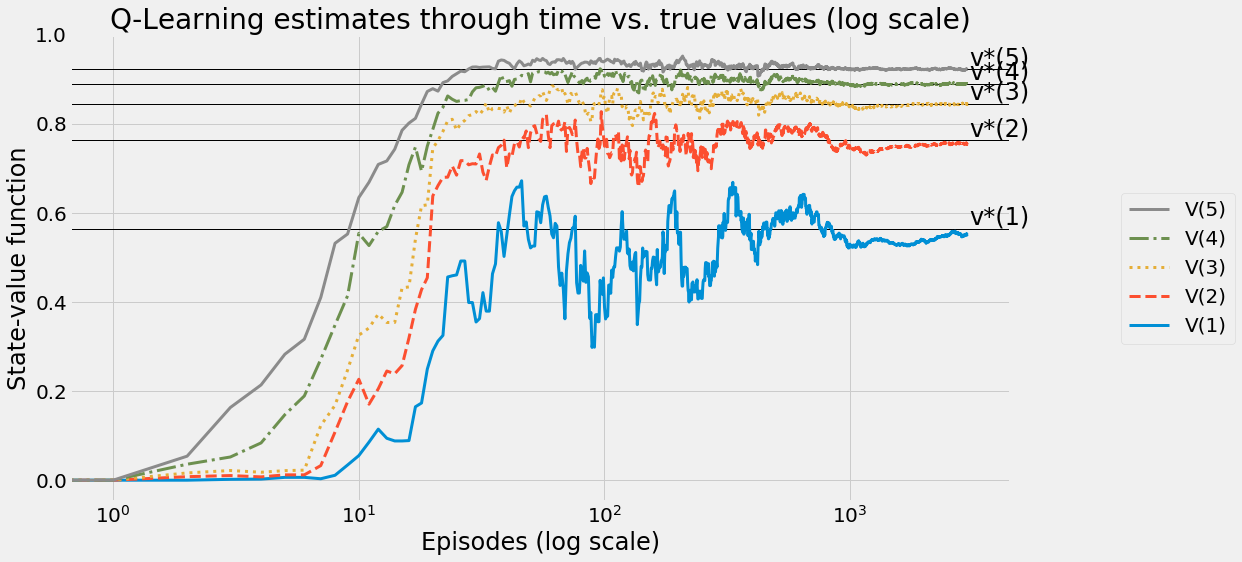

In [37]:
plot_value_function(
    'Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

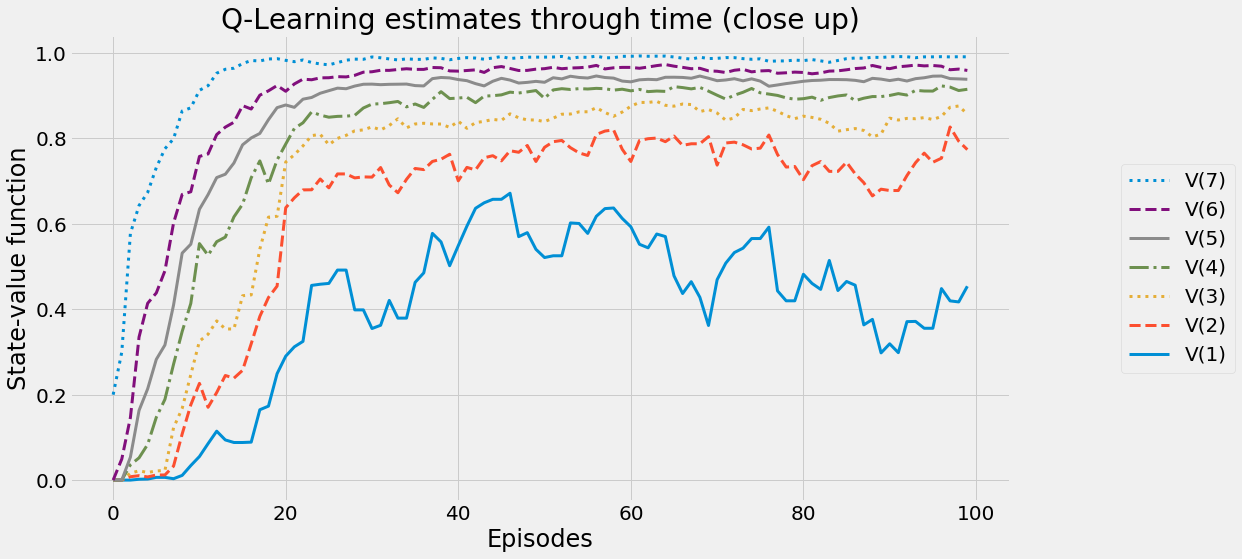

In [38]:
plot_value_function(
    'Q-Learning estimates through time (close up)', 
    np.max(Q_track_ql, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

## Double Q-Learning

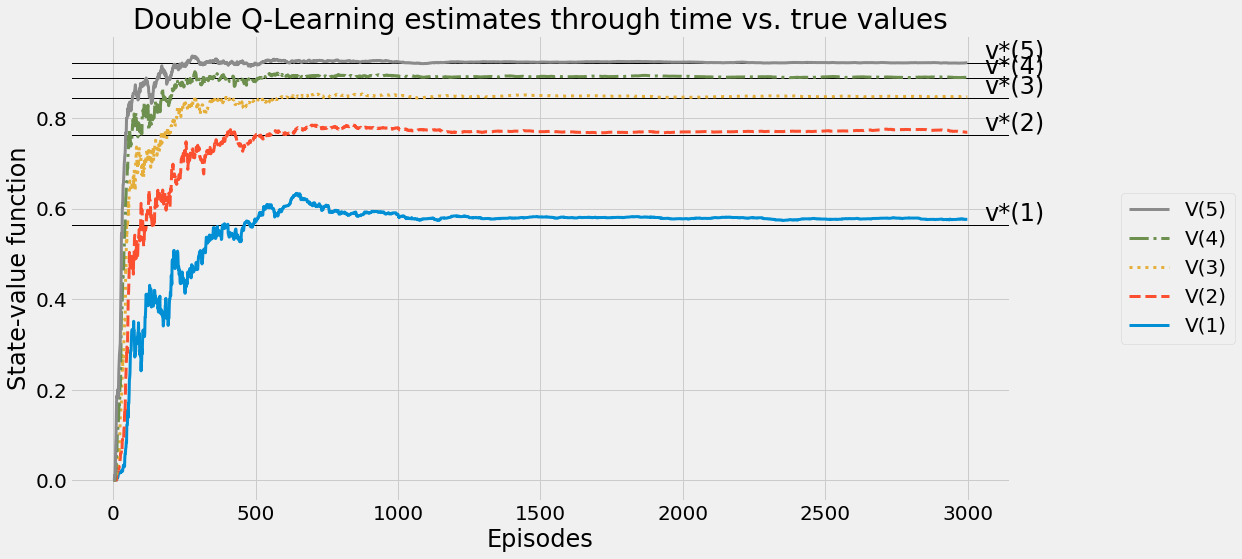

In [39]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values', 
    np.max(Q_track_dql, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

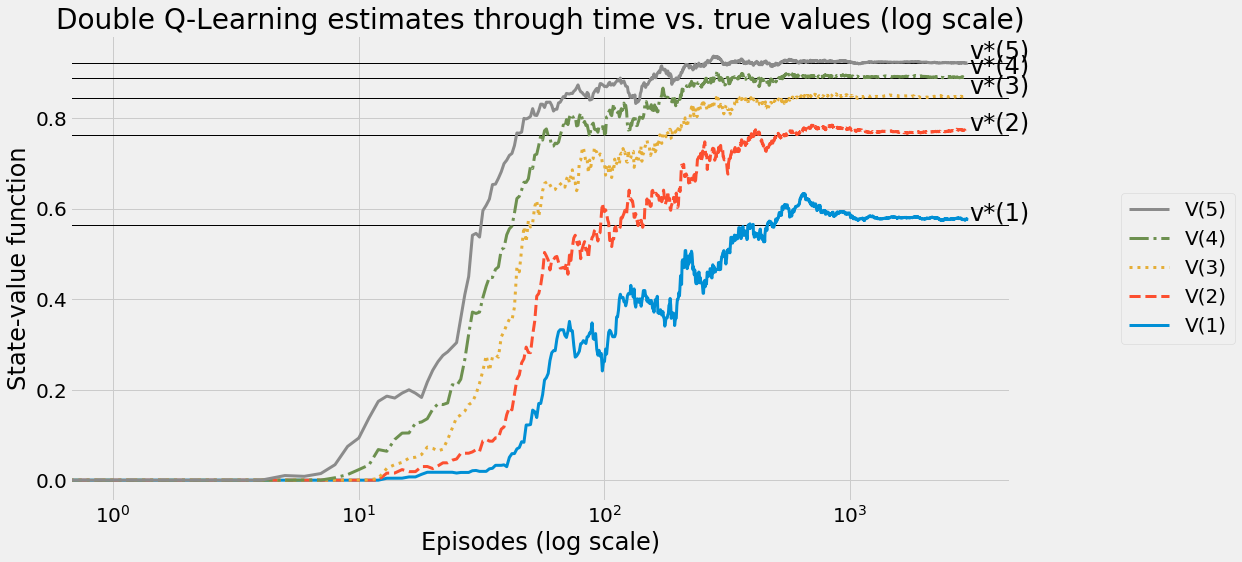

In [40]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_dql, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

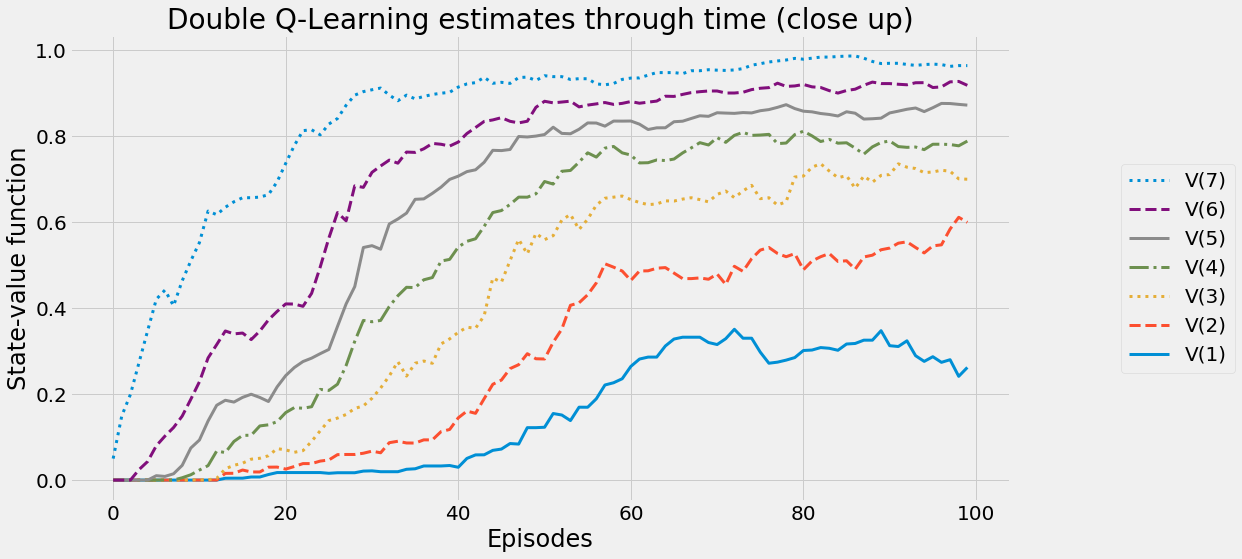

In [41]:
plot_value_function(
    'Double Q-Learning estimates through time (close up)', 
    np.max(Q_track_dql, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

# Policy evolution comparison

In [42]:
mc_success_rate_ma, mc_mean_return_ma, mc_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_mc)

In [43]:
sarsa_success_rate_ma, sarsa_mean_return_ma, sarsa_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_sarsa)

In [44]:
ql_success_rate_ma, ql_mean_return_ma, ql_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_ql)

In [45]:
dql_success_rate_ma, dql_mean_return_ma, dql_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_dql)

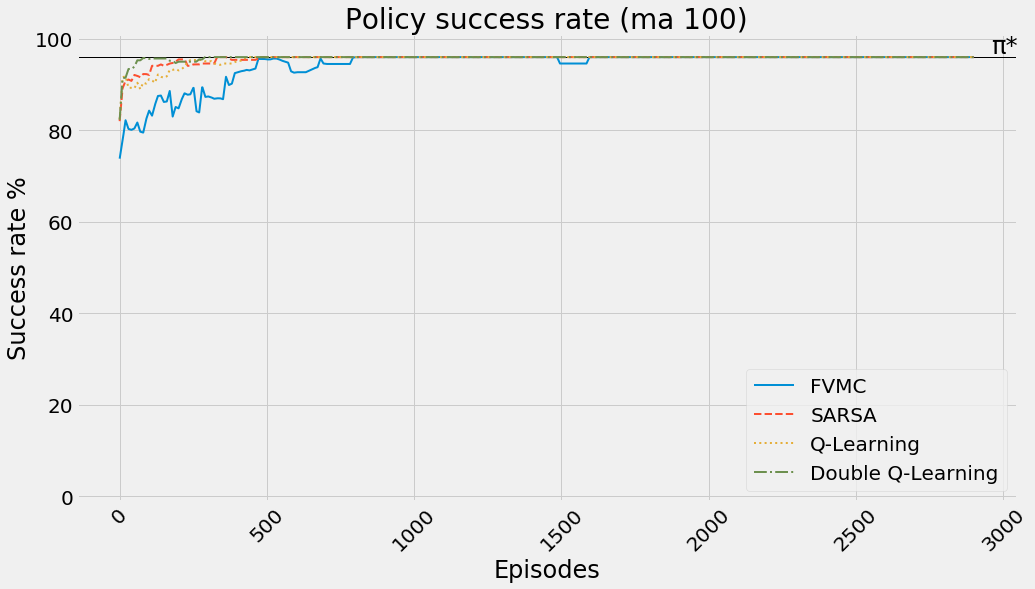

In [46]:
plt.axhline(y=success_rate_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_success_rate_ma)*1.02), success_rate_op*1.01, 'π*')

plt.plot(mc_success_rate_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_success_rate_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_success_rate_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_success_rate_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy success rate (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.ylim(-1, 101)
plt.xticks(rotation=45)

plt.show()

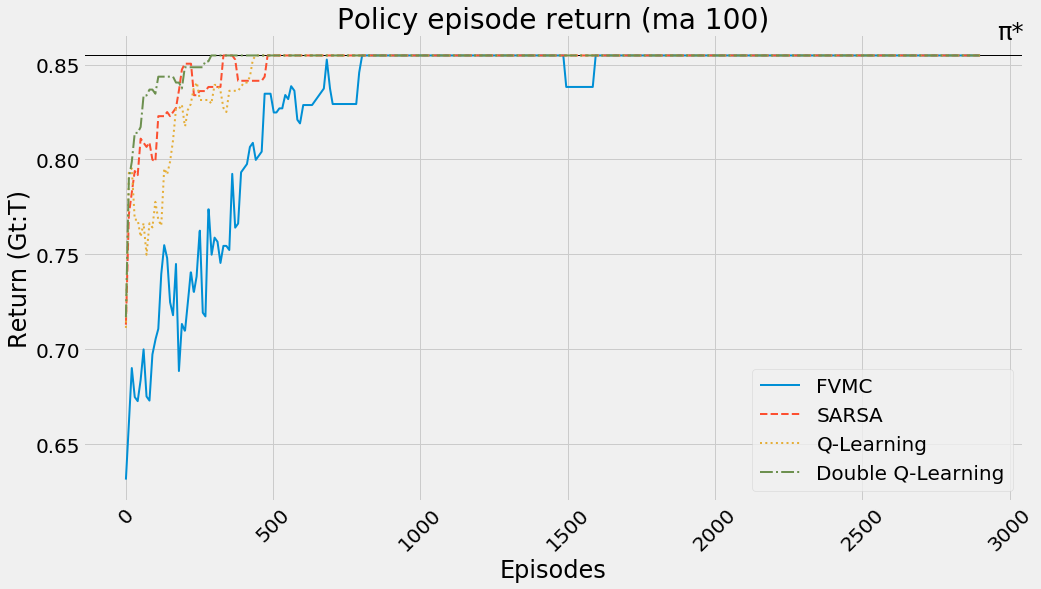

In [47]:
plt.axhline(y=mean_return_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_mean_return_ma)*1.02), mean_return_op*1.01, 'π*')

plt.plot(mc_mean_return_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_return_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_mean_return_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_return_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy episode return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Return (Gt:T)')

plt.xticks(rotation=45)

plt.show()

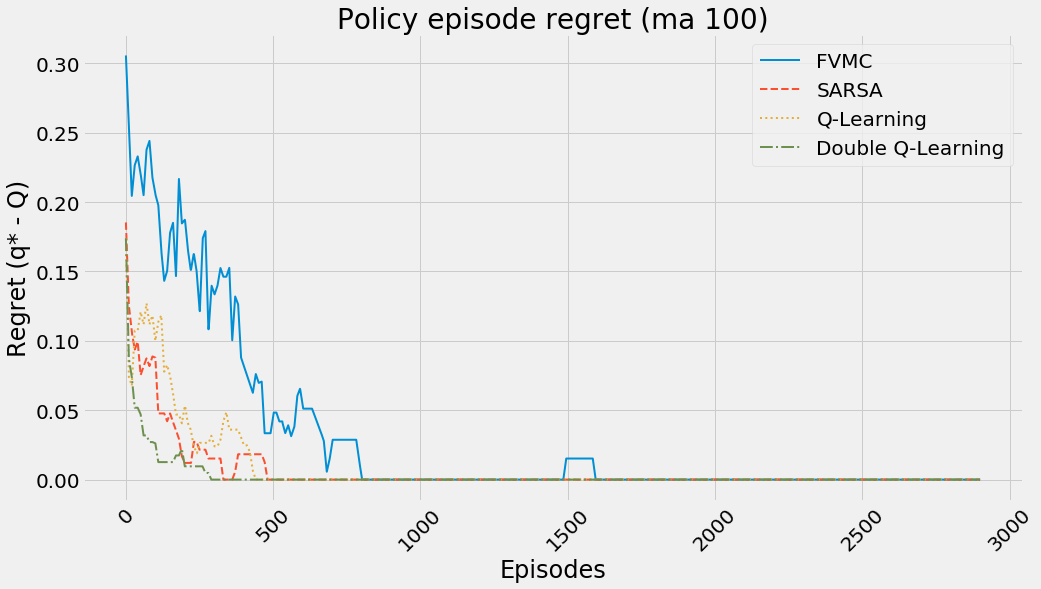

In [48]:
plt.plot(mc_mean_regret_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_regret_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_mean_regret_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_regret_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Policy episode regret (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Regret (q* - Q)')
plt.xticks(rotation=45)

plt.show()

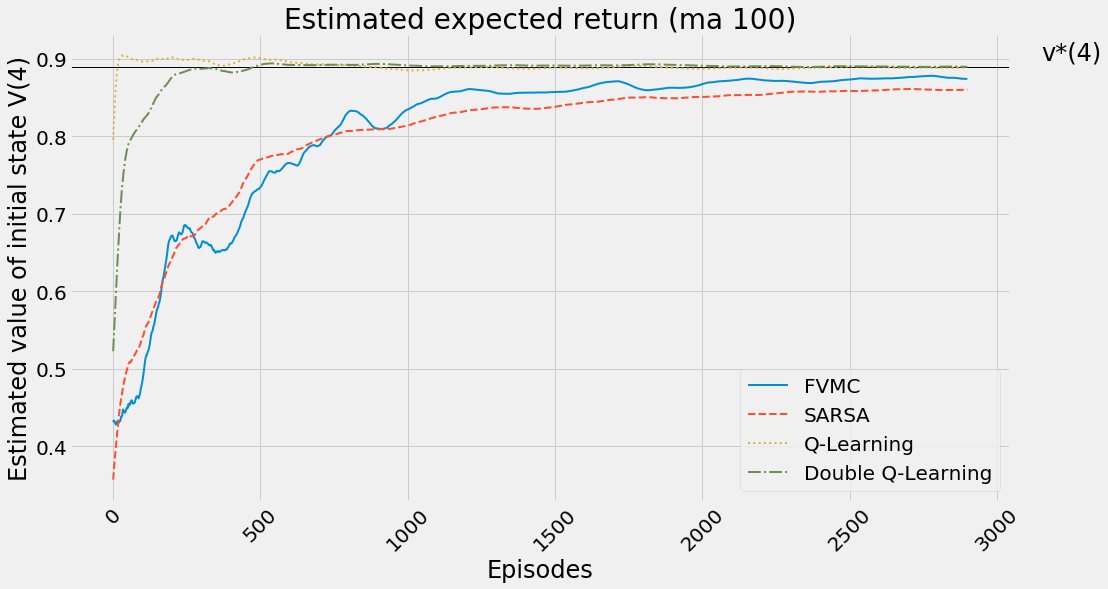

In [49]:
plt.axhline(y=optimal_V[init_state], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_mc)*1.05), optimal_V[init_state]+.01, 'v*({})'.format(init_state))

plt.plot(moving_average(np.max(Q_track_mc, axis=2).T[init_state]), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.max(Q_track_sarsa, axis=2).T[init_state]), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.max(Q_track_ql, axis=2).T[init_state]), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.max(Q_track_dql, axis=2).T[init_state]), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Estimated expected return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state V({})'.format(init_state))
plt.xticks(rotation=45)

plt.show()

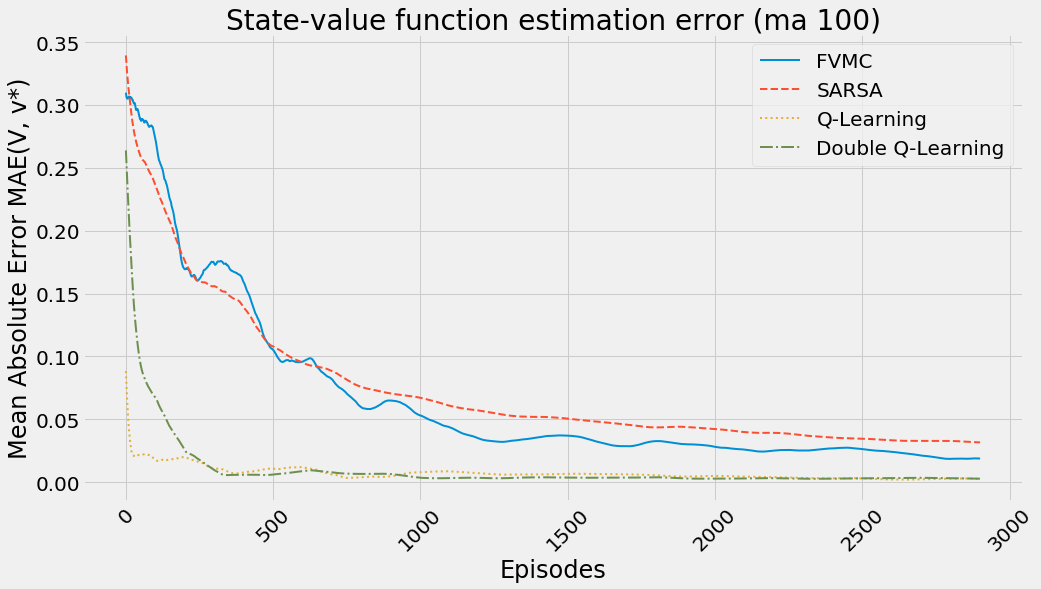

In [50]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_mc, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sarsa, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_ql, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dql, axis=2) - optimal_V), axis=1)), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')
plt.xticks(rotation=45)

plt.show()

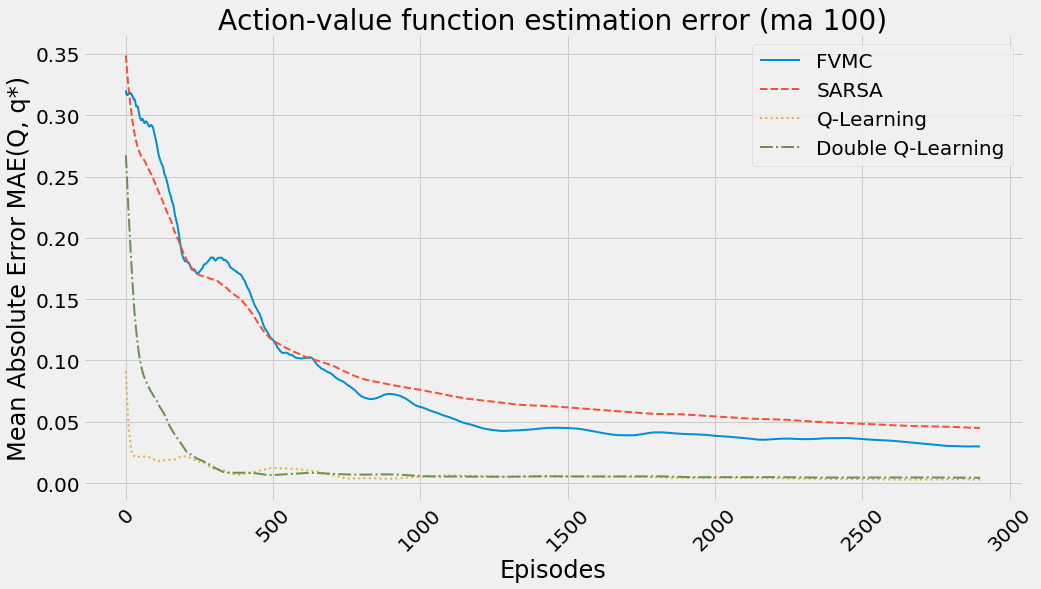

In [51]:
plt.plot(moving_average(np.mean(np.abs(Q_track_mc - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(Q_track_sarsa - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(Q_track_ql - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(Q_track_dql - optimal_Q), axis=(1,2))), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Action-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(Q, q*)')
plt.xticks(rotation=45)

plt.show()

# Russell & Norvig's Gridworld

In [52]:
env = gym.make('RussellNorvigGridworld-v0')
init_state = env.reset()
goal_state = 3
gamma = 1.0
n_episodes = 4000
P = env.env.P
n_cols, svf_prec, err_prec, avf_prec=4, 4, 2, 3
action_symbols=('<', 'v', '>', '^')
limit_items, limit_value = 5, 0.01
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.0, 1000

## Alpha and Epsilon schedules

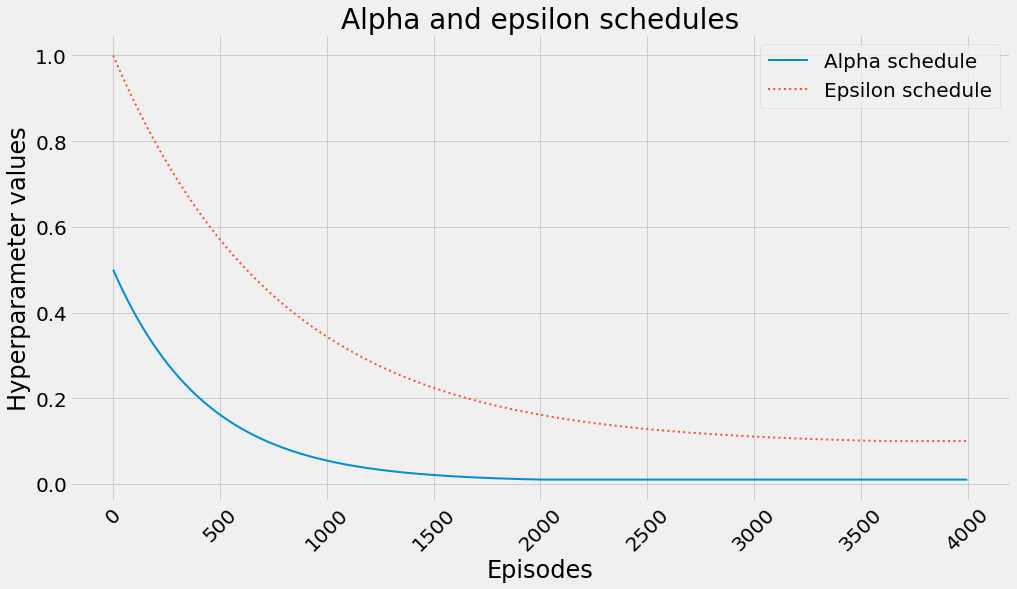

In [53]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes), 
         '-', linewidth=2, 
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes), 
         ':', linewidth=2, 
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

## Optimal value functions and policy

In [54]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |

Optimal action-value function:
╒═════╤═══════╤═══════╤════════╤════════╕
│   s │     < │     v │      > │      ^ │
╞═════╪═══════╪═══════╪════════╪════════╡
│   0 │ 0.767 │ 0.737 │  0.812 │  0.777 │
├─────┼───────┼───────┼────────┼────────┤
│   1 │ 0.783 │ 0.827 │  0.868 │  0.827 │
├─────┼───────┼───────┼────────┼────────┤
│   2 │ 0.812 │ 0.675 │  0.918 │  0.881 │
├─────┼───────┼───────┼────────┼────────┤
│   3 │ 0     │ 0     │  0     │  0     │
├─────┼───────┼───────┼────────┼────────┤
│   4 │ 0.721 │ 0.677 │  0.721 │  0.762 │
├─────┼───────┼───────┼────────┼────────┤
│   5 │ 0     │ 0     │  0     │  0     │
├─────┼───────┼───────┼────────┼────────┤
│   6 │ 0.641 │ 0.415 │ -0.687 │  0.66  │
├─────┼───────┼───────┼────────┼────────┤
│   7 │ 0     │ 0     │  0     │  0     │
├─────┼───────┼───────┼────────┼

## Monte-Carlo Control

In [55]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs ; del V_mcs ; del Q_track_mcs

In [56]:
print_state_value_function(V_mc, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

State-value function found by FVMC:
| 00 0.7899 | 01 0.8518 | 02 0.9191 |           |
| 04 0.7349 |           | 06 0.6609 |           |
| 08 0.6698 | 09 0.5816 | 10 0.2939 | 11 -0.2194 |
Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |
State-value function errors:
| 00  -0.02 | 01  -0.02 | 02    0.0 |           |
| 04  -0.03 |           | 06    0.0 |           |
| 08  -0.04 | 09  -0.07 | 10  -0.32 | 11  -0.61 |
State-value function RMSE: 0.1995

FVMC action-value function:
╒═════╤════════╤════════╤════════╤════════╤═══════╤═══════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╕
│   s │      < │      v │      > │      ^ │   * < │   * v │    * > │    * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪════════╪════════╪════════╪════════╪═══════╪═══════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╡
│   0 │  0.66  │  0.618 │  0.79  │  0

## Sarsa

In [57]:
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=gamma, n_episodes=n_episodes)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)
del Q_sarsas ; del V_sarsas ; del Q_track_sarsas

In [58]:
print_state_value_function(V_sarsa, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa = get_policy_metrics(
    env, gamma=gamma, pi=pi_sarsa, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa))

State-value function found by SARSA:
| 00 0.7646 | 01 0.8317 | 02 0.9003 |           |
| 04 0.7009 |           | 06 0.6164 |           |
| 08 0.6212 | 09 0.5314 | 10 0.1956 | 11 -0.4743 |
Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |
State-value function errors:
| 00  -0.05 | 01  -0.04 | 02  -0.02 |           |
| 04  -0.06 |           | 06  -0.04 |           |
| 08  -0.08 | 09  -0.12 | 10  -0.42 | 11  -0.86 |
State-value function RMSE: 0.2811

SARSA action-value function:
╒═════╤════════╤════════╤════════╤════════╤═══════╤═══════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╕
│   s │      < │      v │      > │      ^ │   * < │   * v │    * > │    * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪════════╪════════╪════════╪════════╪═══════╪═══════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╡
│   0 │  0.645 │  0.603 │  0.765 │ 

## Q-Learning

In [59]:
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)
del Q_qls ; del V_qls ; del Q_track_qls

In [60]:
print_state_value_function(V_ql, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_ql, mean_return_ql, mean_regret_ql = get_policy_metrics(
    env, gamma=gamma, pi=pi_ql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ql, mean_return_ql, mean_regret_ql))

State-value function found by Q-learning:
| 00 0.8146 | 01 0.8688 | 02 0.9164 |           |
| 04 0.7645 |           | 06 0.6005 |           |
| 08 0.7068 | 09 0.6558 | 10 0.6114 | 11  0.438 |
Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |
State-value function errors:
| 00    0.0 | 01    0.0 | 02   -0.0 |           |
| 04    0.0 |           | 06  -0.06 |           |
| 08    0.0 | 09    0.0 | 10    0.0 | 11   0.05 |
State-value function RMSE: 0.0225

Q-learning action-value function:
╒═════╤═══════╤═══════╤════════╤════════╤═══════╤═══════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │      > │      ^ │   * < │   * v │    * > │    * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═══════╪════════╪════════╪═══════╪═══════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╡
│   0 │ 0.768 │ 0.741 │  0.815 │

## Double Q-Learning

In [61]:
Q_dqls, V_dqls, Q_track_dqls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_dqls.append(Q_dql) ; V_dqls.append(V_dql) ; Q_track_dqls.append(Q_track_dql)
Q_dql, V_dql, Q_track_dql = np.mean(Q_dqls, axis=0), np.mean(V_dqls, axis=0), np.mean(Q_track_dqls, axis=0)
del Q_dqls ; del V_dqls ; del Q_track_dqls

In [62]:
print_state_value_function(V_dql, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_dql, mean_return_dql, mean_regret_dql = get_policy_metrics(
    env, gamma=gamma, pi=pi_dql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dql, mean_return_dql, mean_regret_dql))

State-value function found by Double Q-Learning:
| 00 0.8098 | 01 0.8667 | 02 0.9186 |           |
| 04 0.7589 |           | 06 0.6613 |           |
| 08 0.7035 | 09 0.6532 | 10 0.5885 | 11 0.3222 |
Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |
State-value function errors:
| 00   -0.0 | 01   -0.0 | 02    0.0 |           |
| 04   -0.0 |           | 06    0.0 |           |
| 08   -0.0 | 09   -0.0 | 10  -0.02 | 11  -0.07 |
State-value function RMSE: 0.0201

Double Q-Learning action-value function:
╒═════╤═══════╤═══════╤════════╤════════╤═══════╤═══════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │      > │      ^ │   * < │   * v │    * > │    * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═══════╪════════╪════════╪═══════╪═══════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╡
│   0 │ 0.761 │ 0.

# Comparison of max(Q) for every episode

## First-visit Monte-Carlo

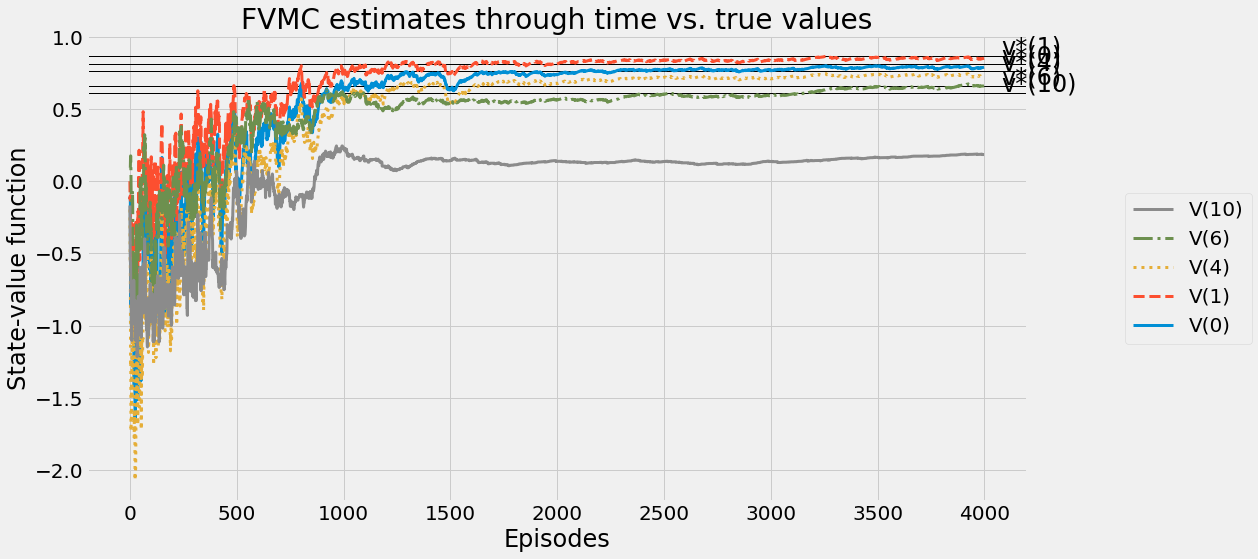

In [63]:
plot_value_function(
    'FVMC estimates through time vs. true values', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

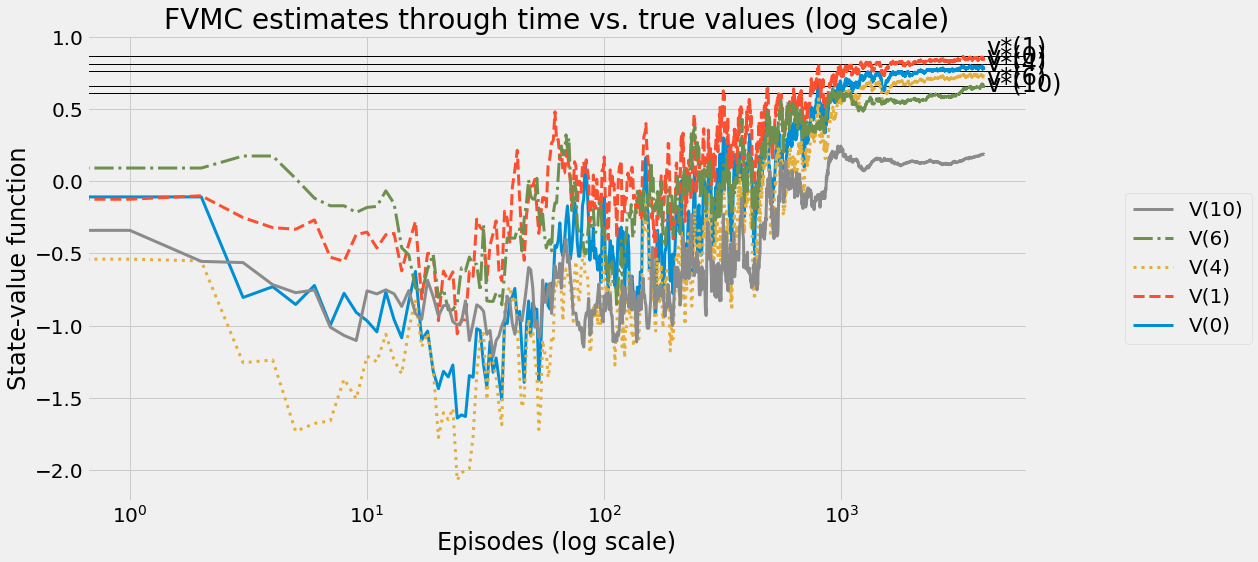

In [64]:
plot_value_function(
    'FVMC estimates through time vs. true values (log scale)', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

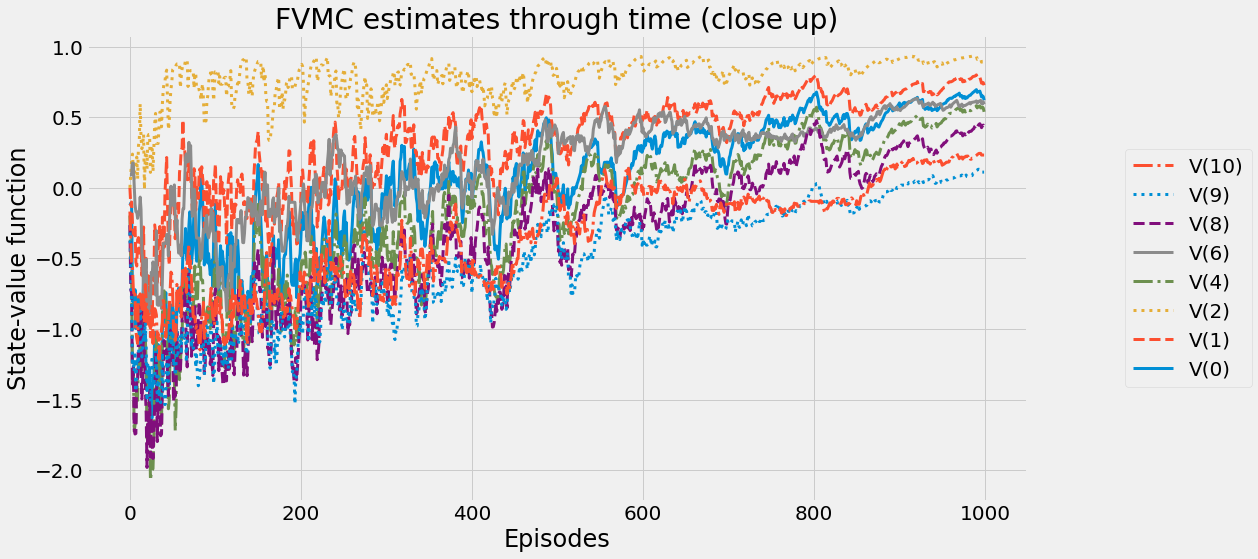

In [65]:
plot_value_function(
    'FVMC estimates through time (close up)', 
    np.max(Q_track_mc, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

## SARSA

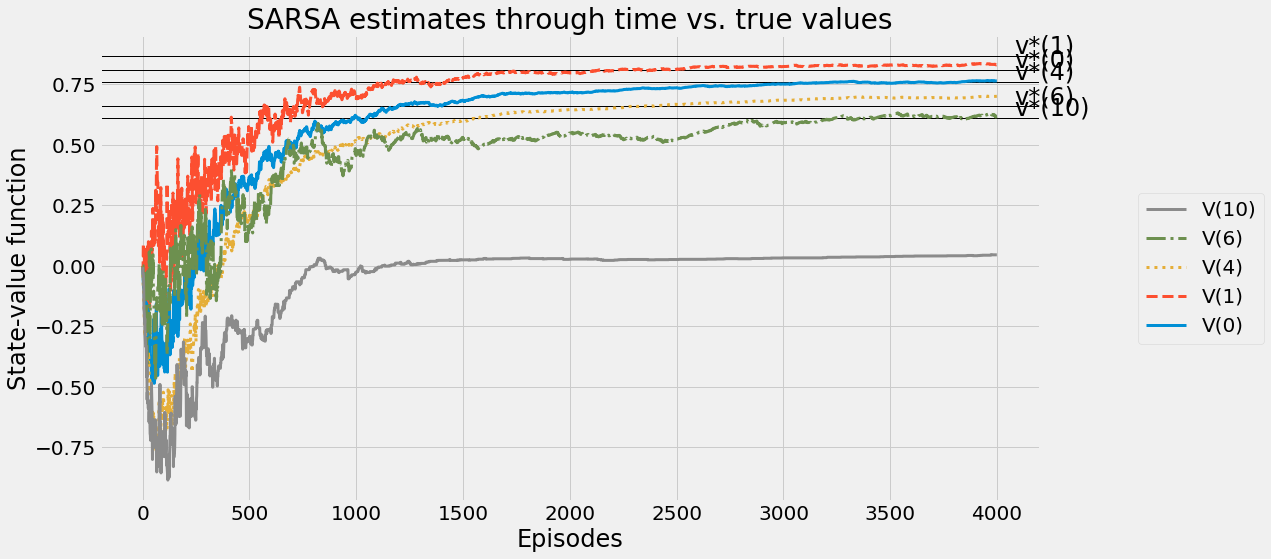

In [66]:
plot_value_function(
    'SARSA estimates through time vs. true values', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

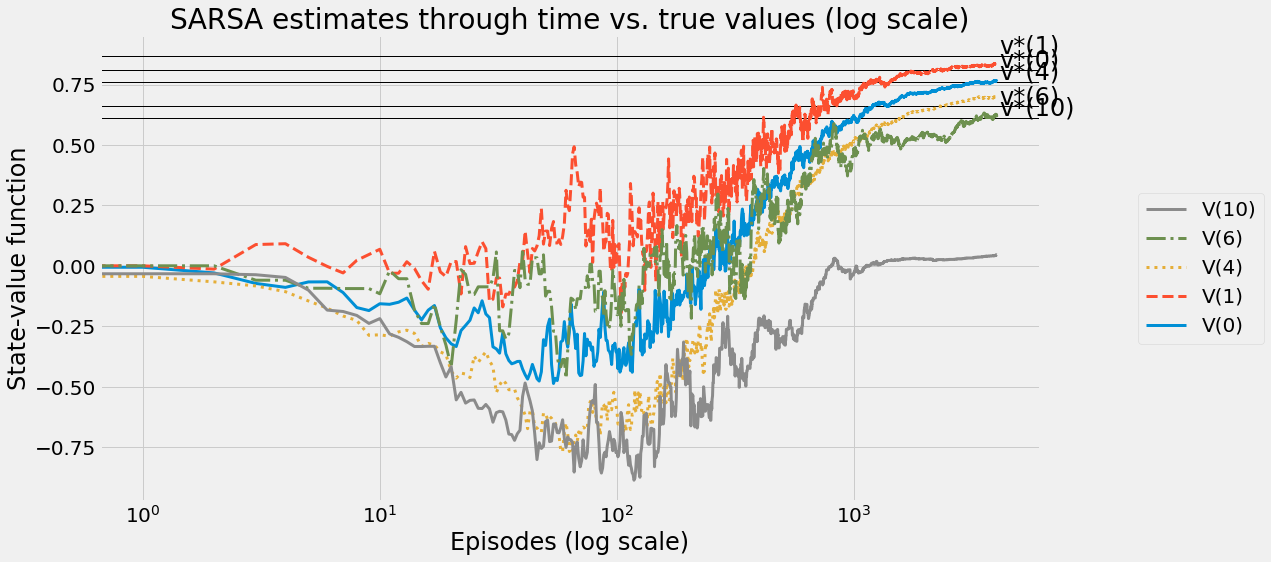

In [67]:
plot_value_function(
    'SARSA estimates through time vs. true values (log scale)', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

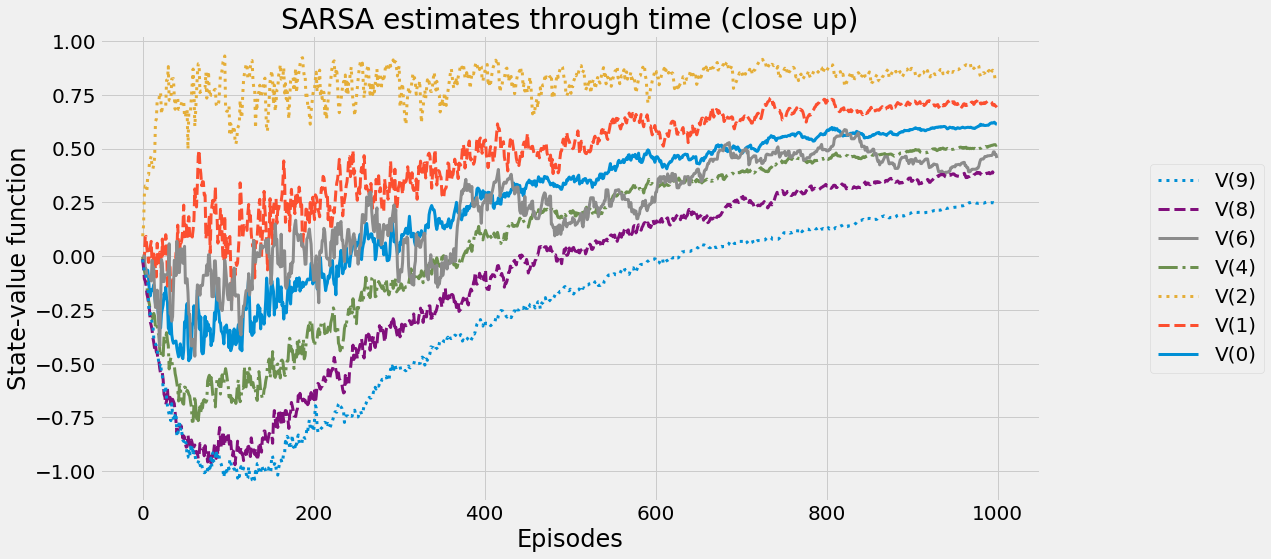

In [68]:
plot_value_function(
    'SARSA estimates through time (close up)', 
    np.max(Q_track_sarsa, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

## Q-learning

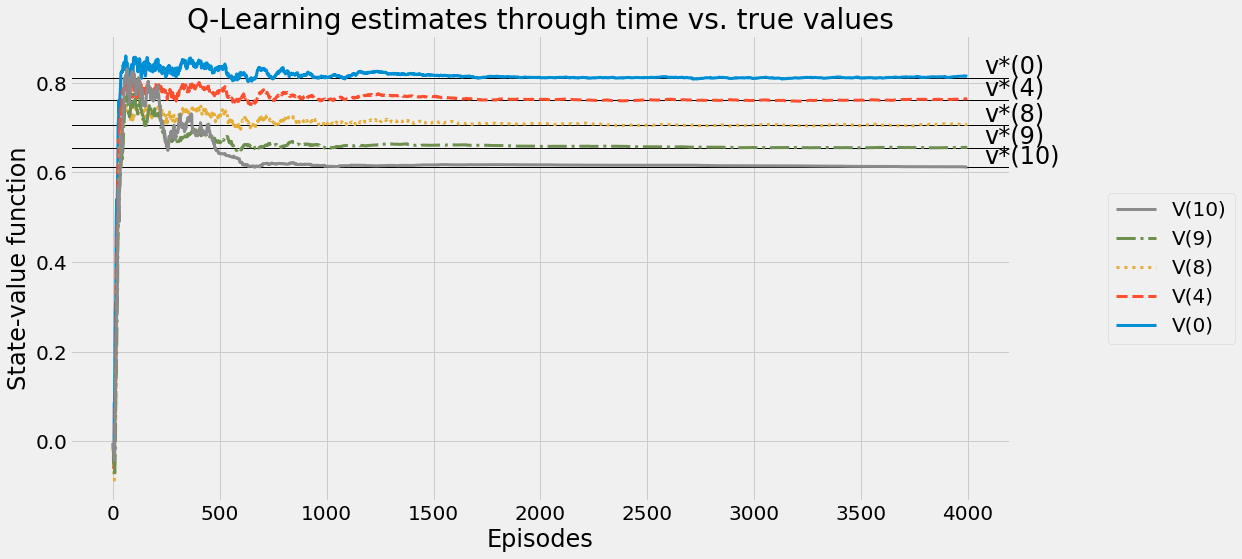

In [69]:
plot_value_function(
    'Q-Learning estimates through time vs. true values', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

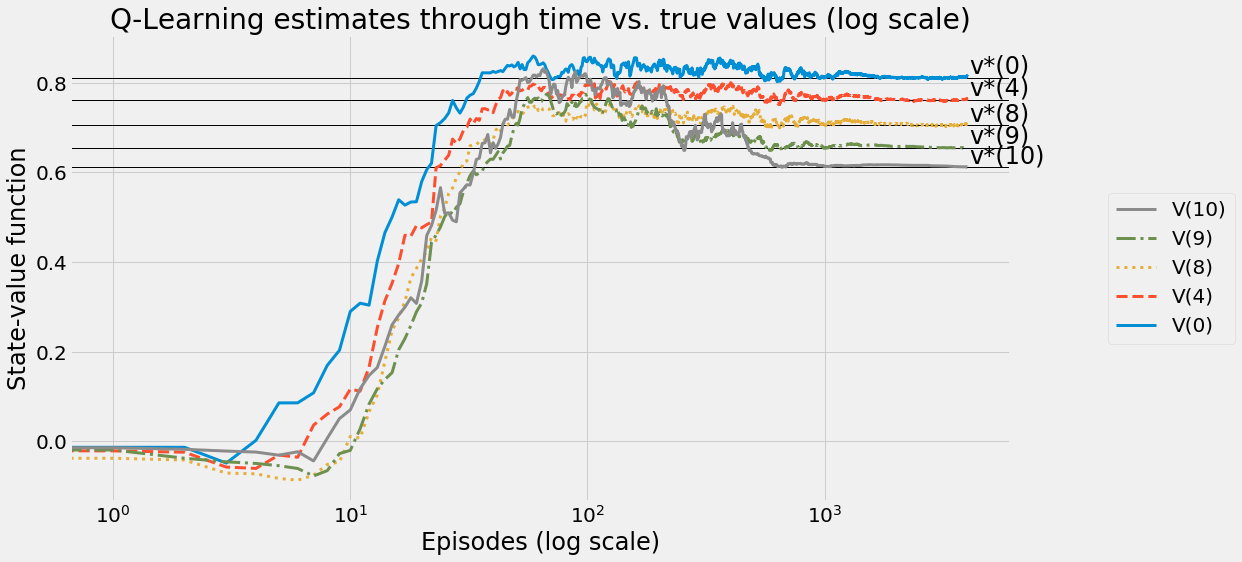

In [70]:
plot_value_function(
    'Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

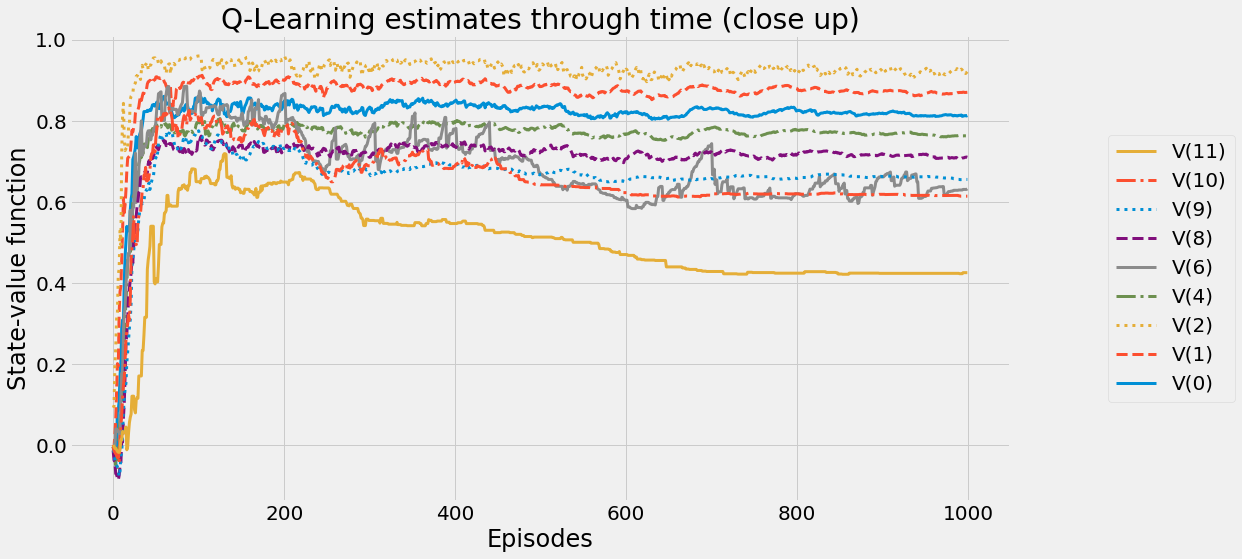

In [71]:
plot_value_function(
    'Q-Learning estimates through time (close up)', 
    np.max(Q_track_ql, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

## Double Q-Learning

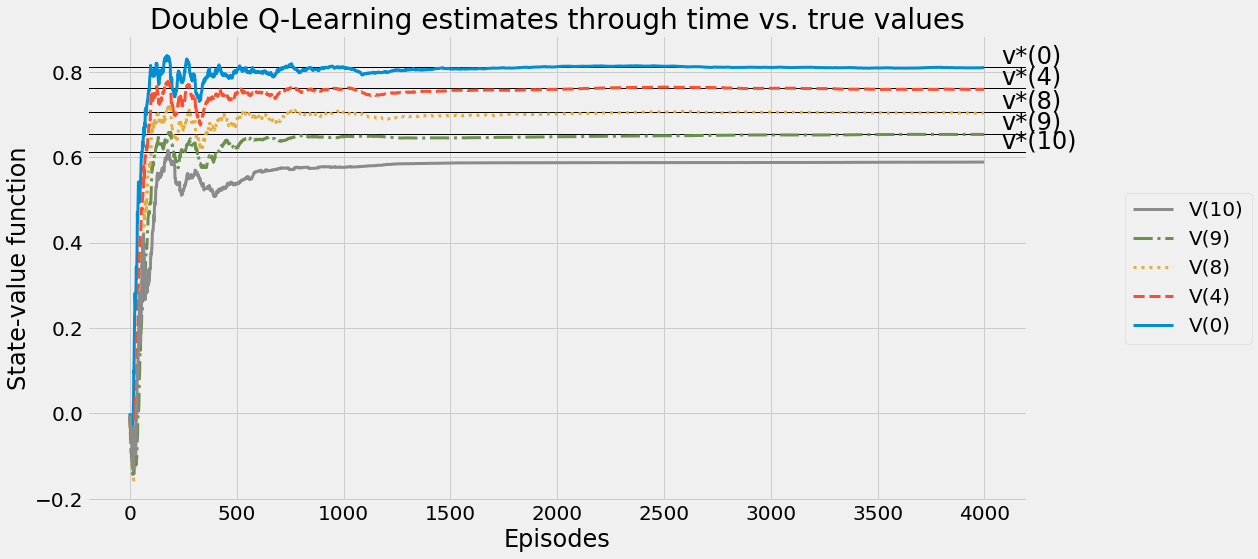

In [72]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values', 
    np.max(Q_track_dql, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

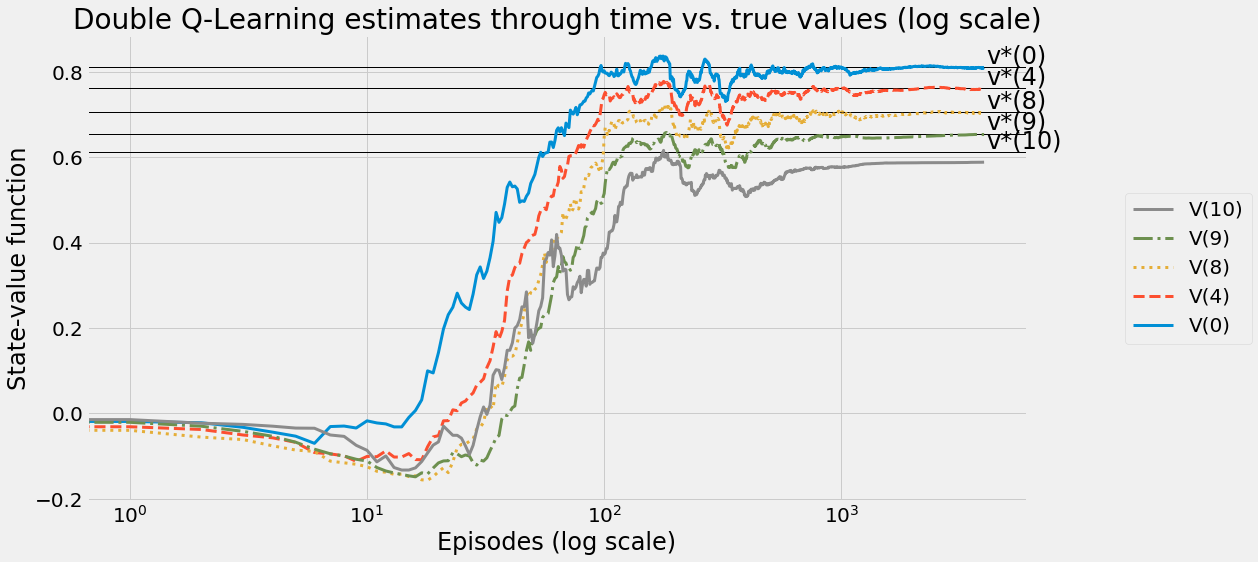

In [73]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_dql, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

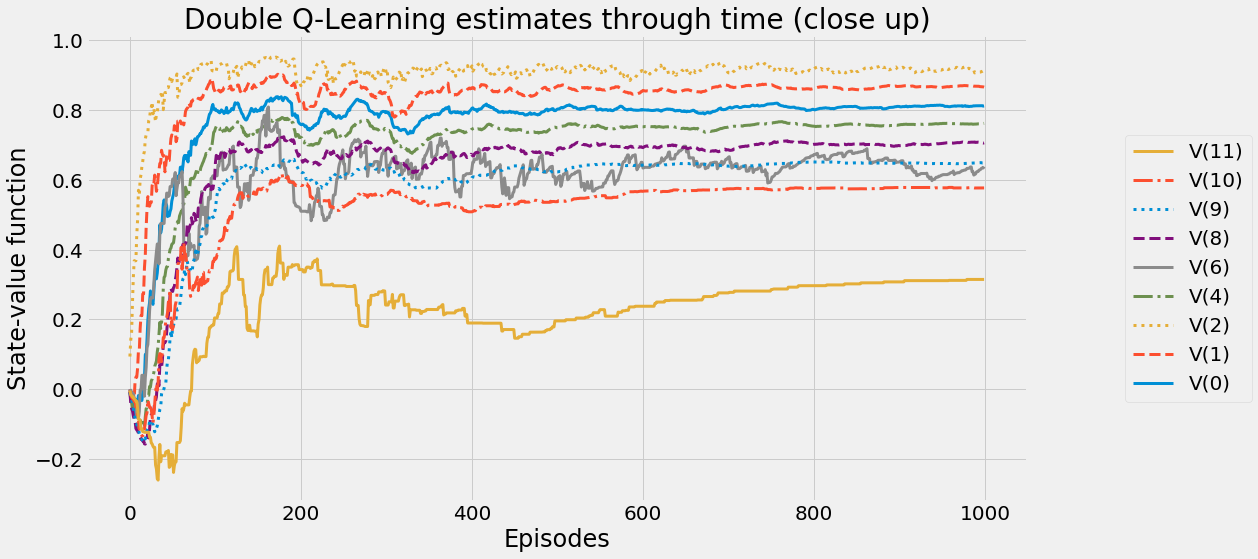

In [74]:
plot_value_function(
    'Double Q-Learning estimates through time (close up)', 
    np.max(Q_track_dql, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

# Policy evolution comparison

In [75]:
mc_success_rate_ma, mc_mean_return_ma, mc_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_mc)

In [76]:
sarsa_success_rate_ma, sarsa_mean_return_ma, sarsa_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_sarsa)

In [77]:
ql_success_rate_ma, ql_mean_return_ma, ql_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_ql)

In [78]:
dql_success_rate_ma, dql_mean_return_ma, dql_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_dql)

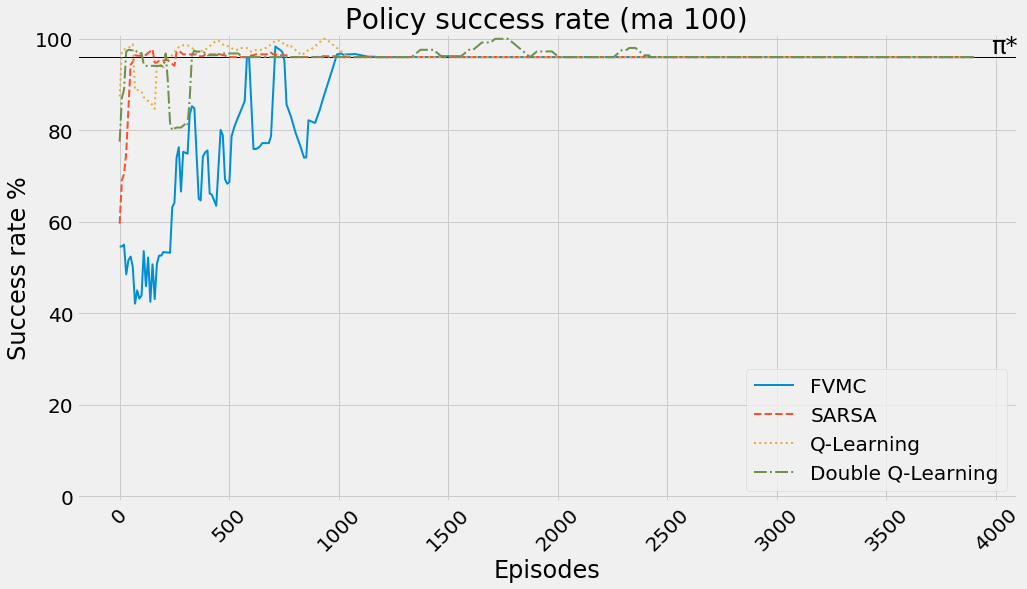

In [79]:
plt.axhline(y=success_rate_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_success_rate_ma)*1.02), success_rate_op*1.01, 'π*')

plt.plot(mc_success_rate_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_success_rate_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_success_rate_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_success_rate_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy success rate (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.ylim(-1, 101)
plt.xticks(rotation=45)

plt.show()

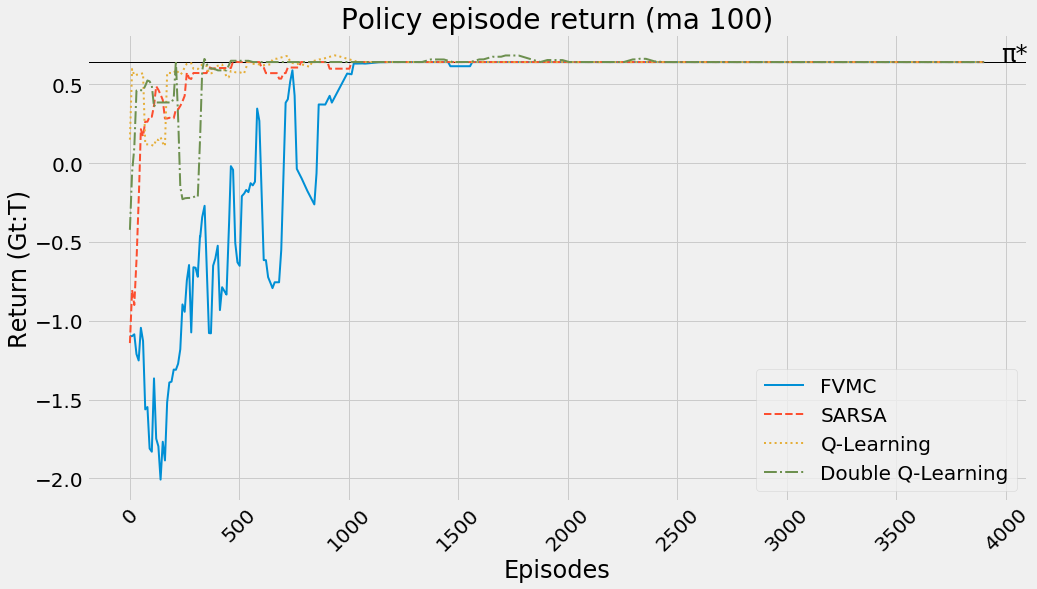

In [80]:
plt.axhline(y=mean_return_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_mean_return_ma)*1.02), mean_return_op*1.01, 'π*')

plt.plot(mc_mean_return_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_return_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_mean_return_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_return_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy episode return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Return (Gt:T)')

plt.xticks(rotation=45)

plt.show()

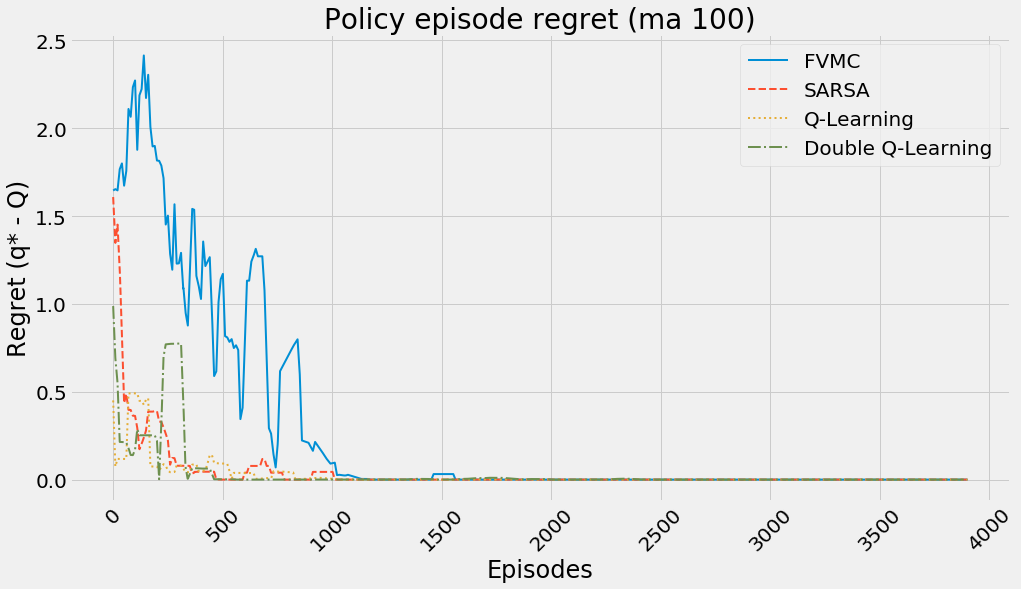

In [81]:
plt.plot(mc_mean_regret_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_regret_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_mean_regret_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_regret_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Policy episode regret (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Regret (q* - Q)')
plt.xticks(rotation=45)

plt.show()

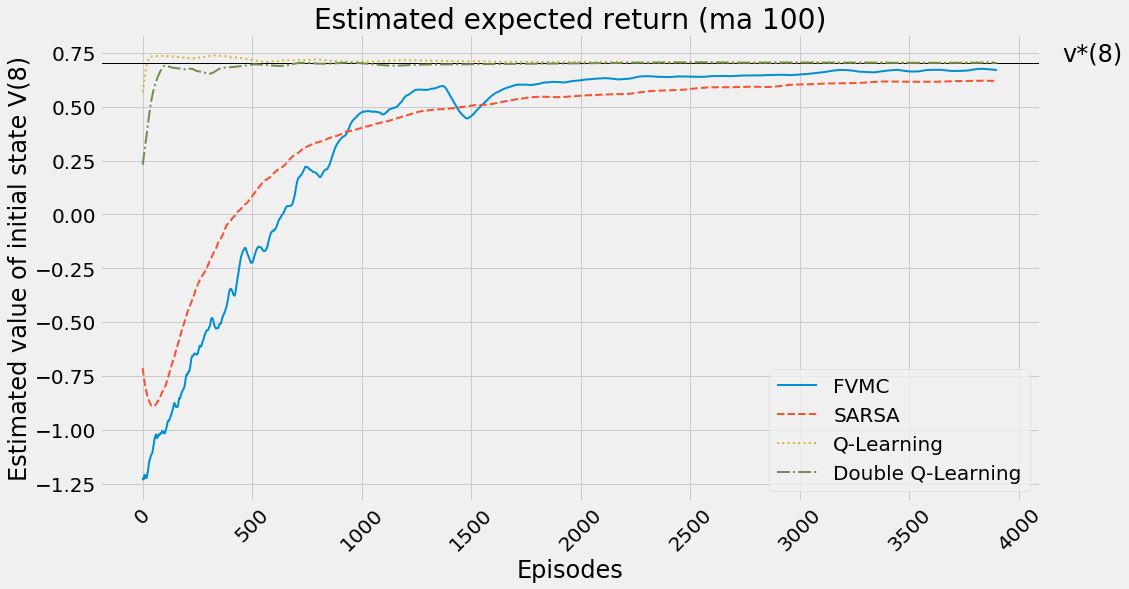

In [82]:
plt.axhline(y=optimal_V[init_state], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_mc)*1.05), optimal_V[init_state]+.01, 'v*({})'.format(init_state))

plt.plot(moving_average(np.max(Q_track_mc, axis=2).T[init_state]), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.max(Q_track_sarsa, axis=2).T[init_state]), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.max(Q_track_ql, axis=2).T[init_state]), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.max(Q_track_dql, axis=2).T[init_state]), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Estimated expected return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state V({})'.format(init_state))
plt.xticks(rotation=45)

plt.show()

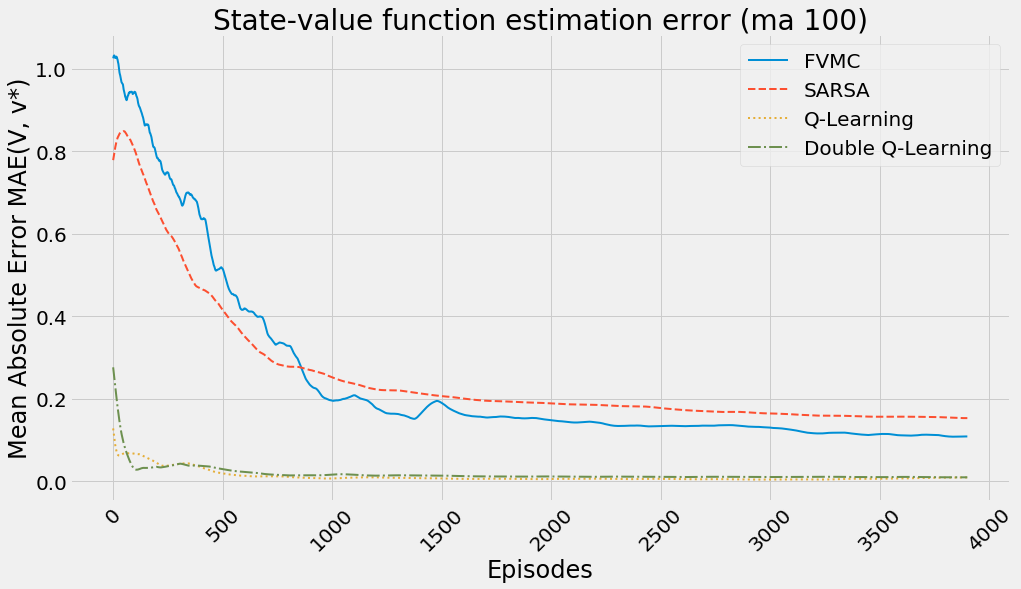

In [83]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_mc, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sarsa, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_ql, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dql, axis=2) - optimal_V), axis=1)), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')
plt.xticks(rotation=45)

plt.show()

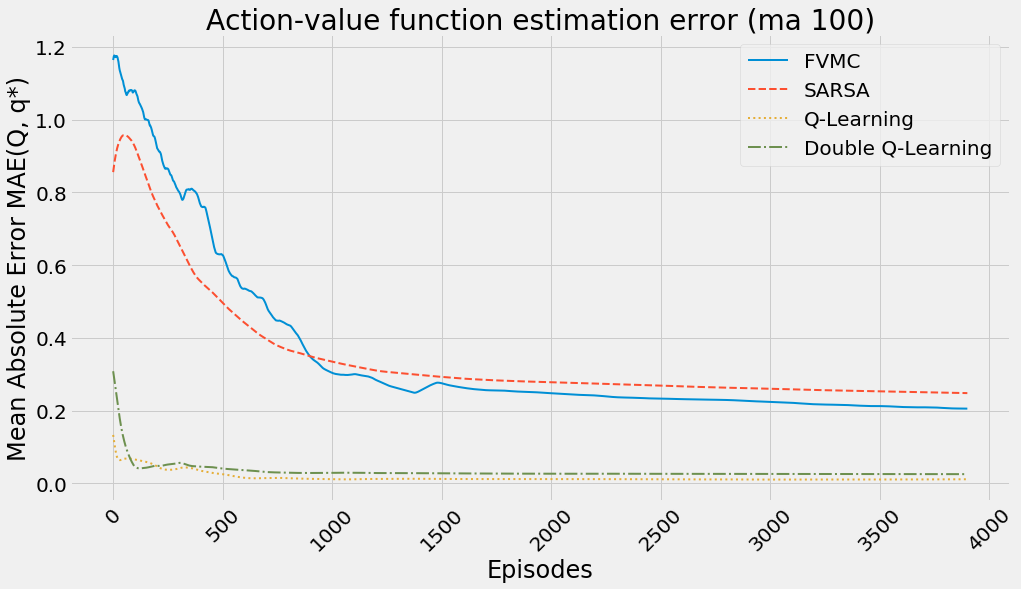

In [84]:
plt.plot(moving_average(np.mean(np.abs(Q_track_mc - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(Q_track_sarsa - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(Q_track_ql - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(Q_track_dql - optimal_Q), axis=(1,2))), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Action-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(Q, q*)')
plt.xticks(rotation=45)

plt.show()

# FrozenLake environment

In [85]:
env = gym.make('FrozenLake-v0')
init_state = env.reset()
goal_state = 15
gamma = 0.99
n_episodes = 10000
P = env.env.P
n_cols, svf_prec, err_prec, avf_prec=4, 4, 2, 3
action_symbols=('<', 'v', '>', '^')
limit_items, limit_value = 5, 0.0
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.01, 2000

## Alpha and Epsilon schedules

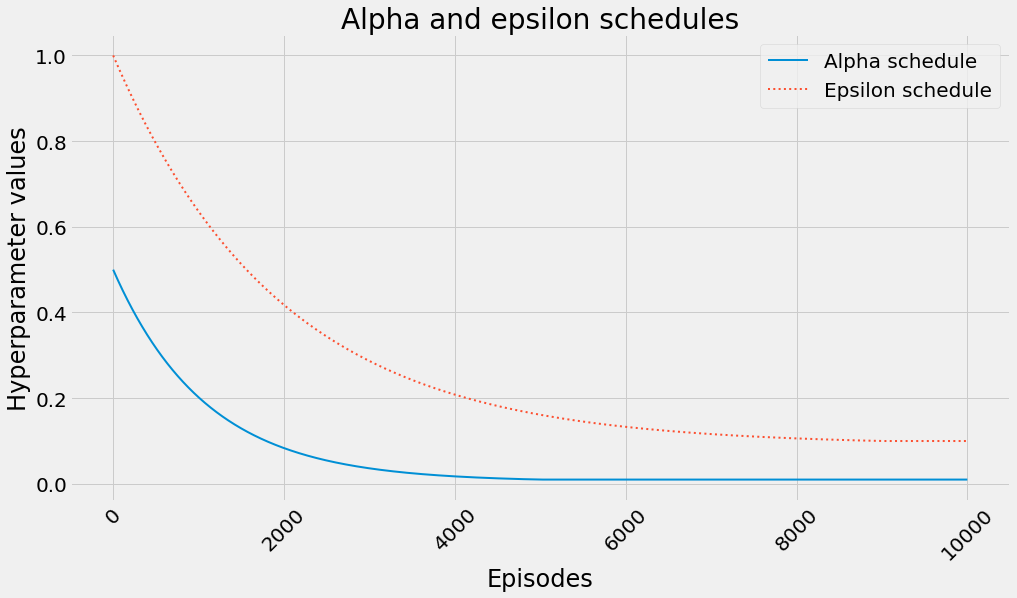

In [86]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes), 
         '-', linewidth=2, 
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes), 
         ':', linewidth=2, 
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

## Optimal value functions and policy

In [87]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |

Optimal action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╕
│   s │     < │     v │     > │     ^ │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│   0 │ 0.542 │ 0.528 │ 0.528 │ 0.522 │
├─────┼───────┼───────┼───────┼───────┤
│   1 │ 0.343 │ 0.334 │ 0.32  │ 0.499 │
├─────┼───────┼───────┼───────┼───────┤
│   2 │ 0.438 │ 0.434 │ 0.424 │ 0.471 │
├─────┼───────┼───────┼───────┼───────┤
│   3 │ 0.306 │ 0.306 │ 0.302 │ 0.457 │
├─────┼───────┼───────┼───────┼───────┤
│   4 │ 0.558 │ 0.38  │ 0.374 │ 0.363 │
├─────┼───────┼───────┼───────┼───────┤
│   5 │ 0     │ 0     │ 0     │ 0     │
├─────┼───────┼───────┼───────┼───────┤
│   6 │ 0.358 │ 0.203 │ 0.358 │ 0.155 │
├─────┼───────┼───────┼───────┼───────┤
│   7 │ 0     │ 0     │ 0     │ 0     │
├─────┼───────┼───

## Monte-Carlo Control

In [88]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs ; del V_mcs ; del Q_track_mcs

In [89]:
print_state_value_function(V_mc, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

State-value function found by FVMC:
| 00 0.2924 | 01 0.1962 | 02 0.1745 | 03 0.0798 |
| 04 0.3093 |           | 06 0.2139 |           |
| 08 0.3592 | 09 0.4479 | 10 0.4471 |           |
|           | 13 0.5975 | 14 0.7784 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.25 | 01   -0.3 | 02   -0.3 | 03  -0.38 |
| 04  -0.25 |           | 06  -0.14 |           |
| 08  -0.23 | 09   -0.2 | 10  -0.17 |           |
|           | 13  -0.14 | 14  -0.08 |           |
State-value function RMSE: 0.1961

FVMC action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═══

## Sarsa

In [90]:
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=gamma, n_episodes=n_episodes)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)
del Q_sarsas ; del V_sarsas ; del Q_track_sarsas

In [91]:
print_state_value_function(V_sarsa, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa = get_policy_metrics(
    env, gamma=gamma, pi=pi_sarsa, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa))

State-value function found by SARSA:
| 00 0.2822 | 01 0.2237 | 02 0.1984 | 03 0.1127 |
| 04 0.3003 |           | 06 0.2074 |           |
| 08 0.3473 | 09 0.4417 | 10 0.4533 |           |
|           | 13 0.5771 | 14 0.7754 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.26 | 01  -0.28 | 02  -0.27 | 03  -0.34 |
| 04  -0.26 |           | 06  -0.15 |           |
| 08  -0.24 | 09   -0.2 | 10  -0.16 |           |
|           | 13  -0.16 | 14  -0.09 |           |
State-value function RMSE: 0.1915

SARSA action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═

## Q-Learning

In [92]:
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)
del Q_qls ; del V_qls ; del Q_track_qls

In [93]:
print_state_value_function(V_ql, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_ql, mean_return_ql, mean_regret_ql = get_policy_metrics(
    env, gamma=gamma, pi=pi_ql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ql, mean_return_ql, mean_regret_ql))

State-value function found by Q-learning:
| 00 0.5219 | 01 0.4762 | 02 0.4434 | 03 0.4284 |
| 04  0.539 |           | 06 0.3521 |           |
| 08 0.5742 | 09 0.6247 | 10 0.6011 |           |
|           | 13 0.7321 | 14 0.8545 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.02 | 01  -0.02 | 02  -0.03 | 03  -0.03 |
| 04  -0.02 |           | 06  -0.01 |           |
| 08  -0.02 | 09  -0.02 | 10  -0.01 |           |
|           | 13  -0.01 | 14  -0.01 |           |
State-value function RMSE: 0.0156

Q-learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════

## Double Q-Learning

In [94]:
Q_dqls, V_dqls, Q_track_dqls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_dqls.append(Q_dql) ; V_dqls.append(V_dql) ; Q_track_dqls.append(Q_track_dql)
Q_dql, V_dql, Q_track_dql = np.mean(Q_dqls, axis=0), np.mean(V_dqls, axis=0), np.mean(Q_track_dqls, axis=0)
del Q_dqls ; del V_dqls ; del Q_track_dqls

In [95]:
print_state_value_function(V_dql, P, n_cols=n_cols, 
                           prec=svf_prec, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols, 
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=n_cols, 
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=action_symbols, 
                            prec=avf_prec, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_dql, mean_return_dql, mean_regret_dql = get_policy_metrics(
    env, gamma=gamma, pi=pi_dql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dql, mean_return_dql, mean_regret_dql))

State-value function found by Double Q-Learning:
| 00 0.5184 | 01 0.4354 | 02 0.3635 | 03 0.1936 |
| 04  0.535 |           | 06 0.3091 |           |
| 08 0.5681 | 09 0.6211 | 10 0.5848 |           |
|           | 13 0.7279 | 14 0.8563 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.02 | 01  -0.06 | 02  -0.11 | 03  -0.26 |
| 04  -0.02 |           | 06  -0.05 |           |
| 08  -0.02 | 09  -0.02 | 10  -0.03 |           |
|           | 13  -0.01 | 14  -0.01 |           |
State-value function RMSE: 0.0752

Double Q-Learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   

# Comparison of max(Q) for every episode

## First-visit Monte-Carlo

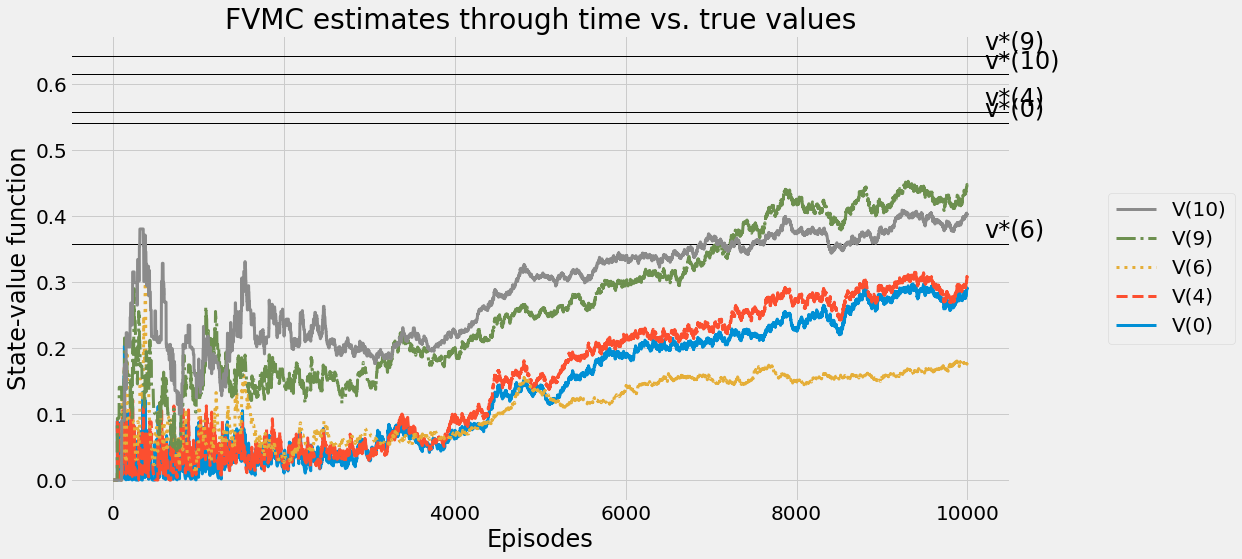

In [96]:
plot_value_function(
    'FVMC estimates through time vs. true values', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

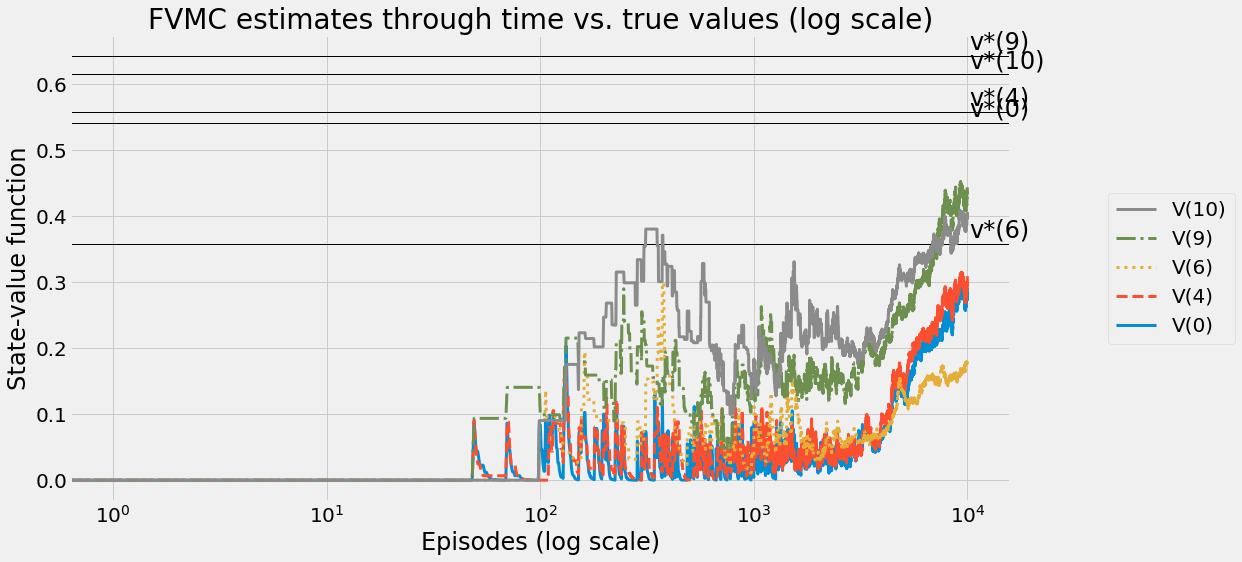

In [97]:
plot_value_function(
    'FVMC estimates through time vs. true values (log scale)', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

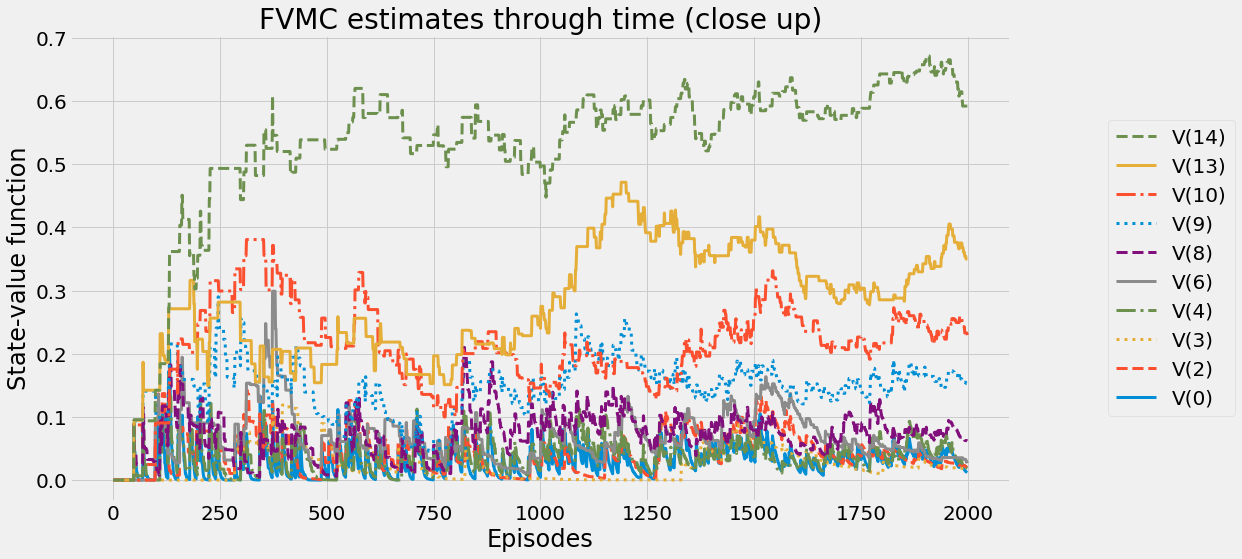

In [98]:
plot_value_function(
    'FVMC estimates through time (close up)', 
    np.max(Q_track_mc, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

## SARSA

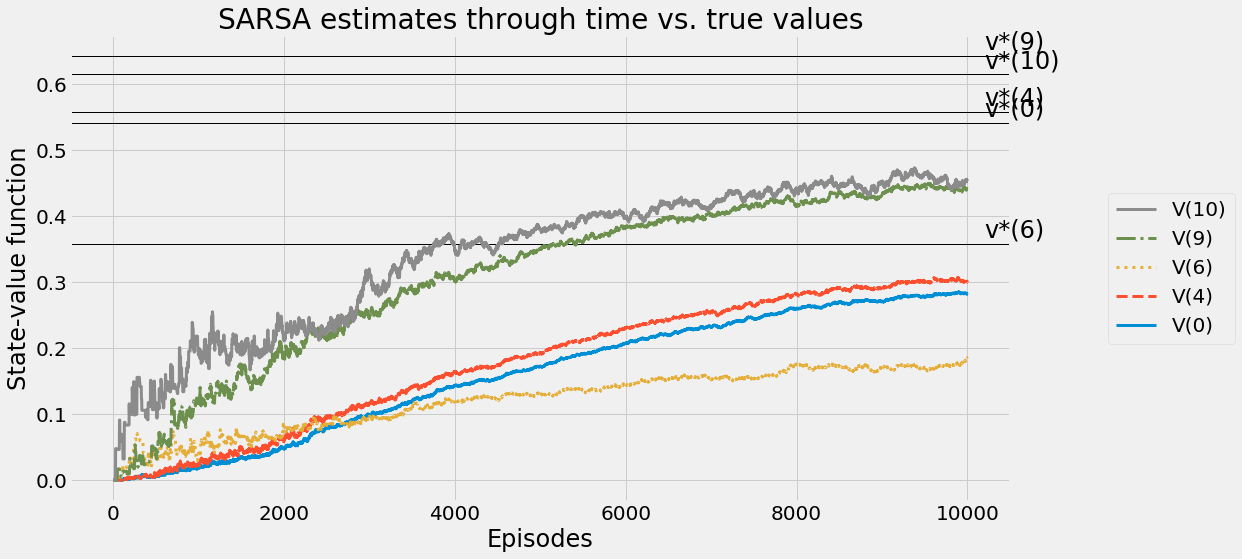

In [99]:
plot_value_function(
    'SARSA estimates through time vs. true values', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

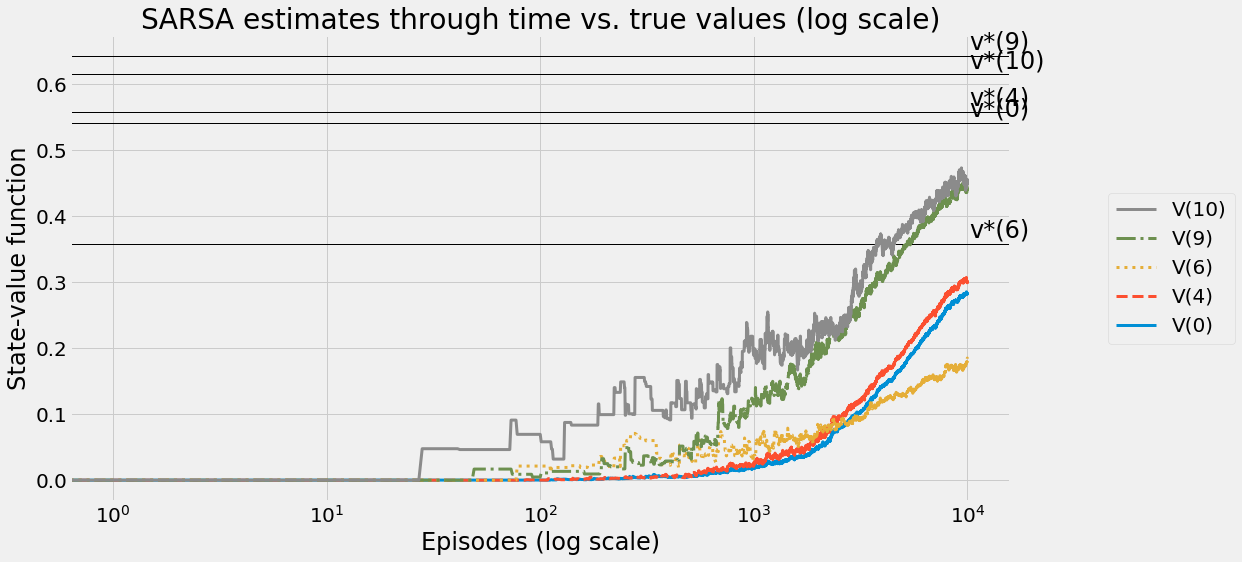

In [100]:
plot_value_function(
    'SARSA estimates through time vs. true values (log scale)', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

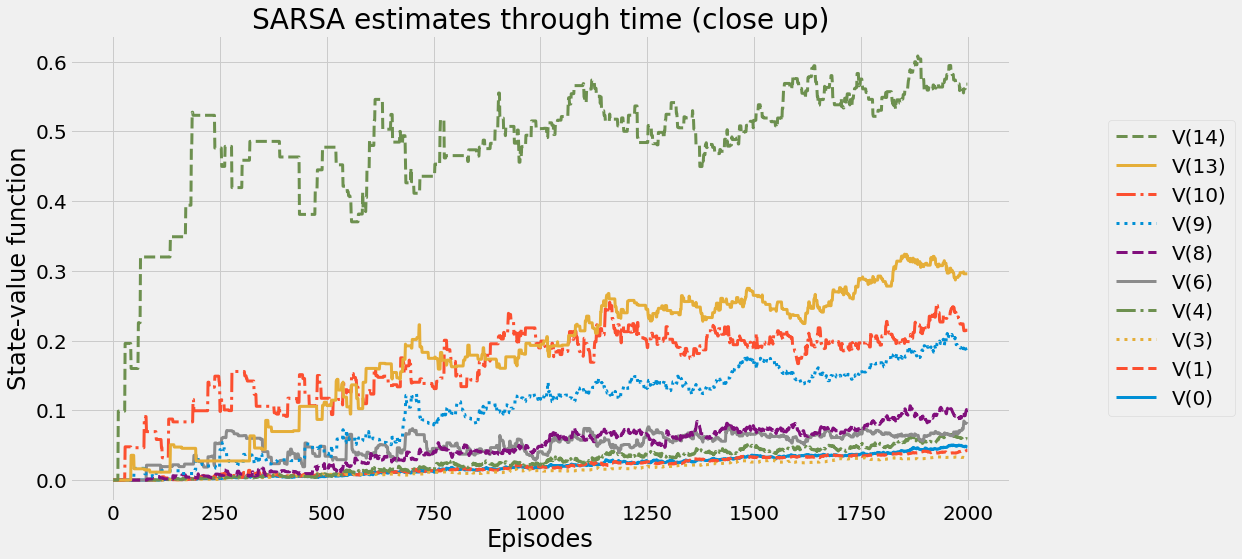

In [101]:
plot_value_function(
    'SARSA estimates through time (close up)', 
    np.max(Q_track_sarsa, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

## Q-learning

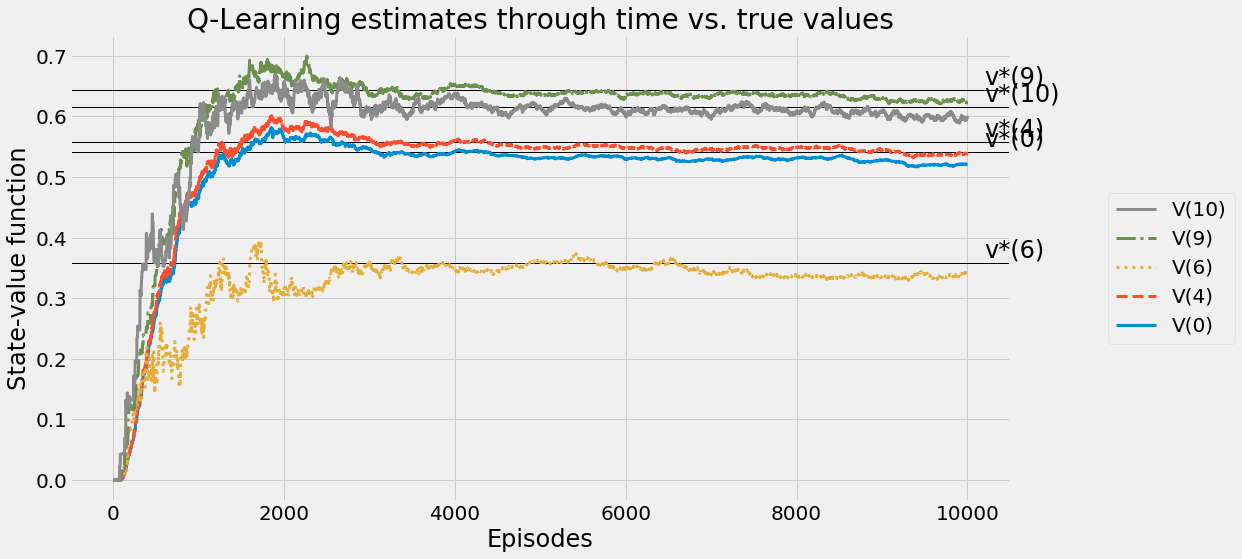

In [102]:
plot_value_function(
    'Q-Learning estimates through time vs. true values', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

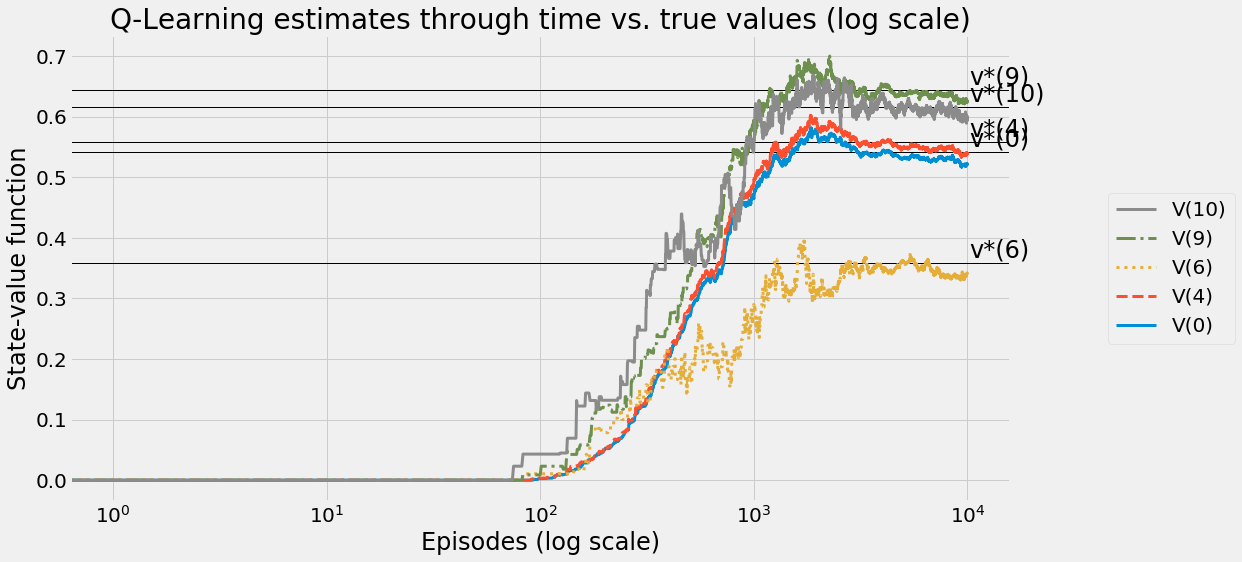

In [103]:
plot_value_function(
    'Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

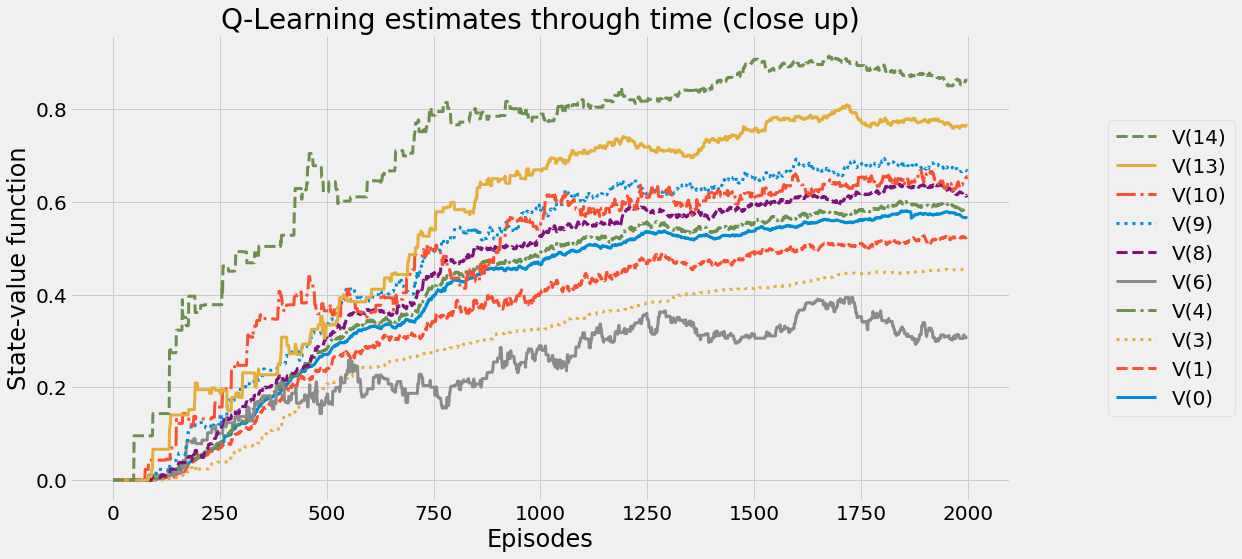

In [104]:
plot_value_function(
    'Q-Learning estimates through time (close up)', 
    np.max(Q_track_ql, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

## Double Q-Learning

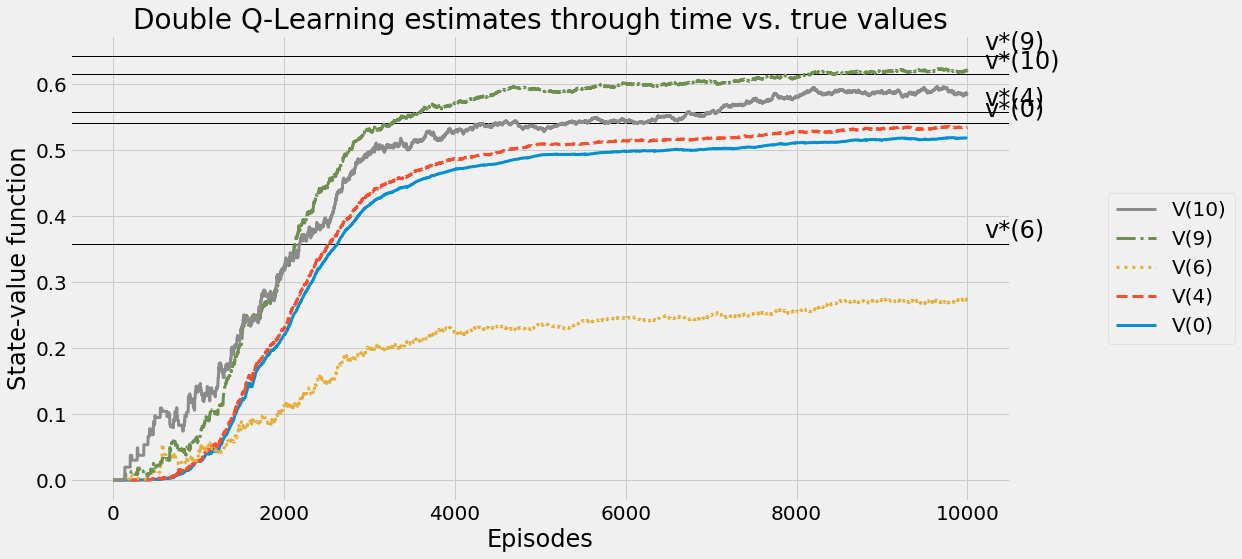

In [105]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values', 
    np.max(Q_track_dql, axis=2), 
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

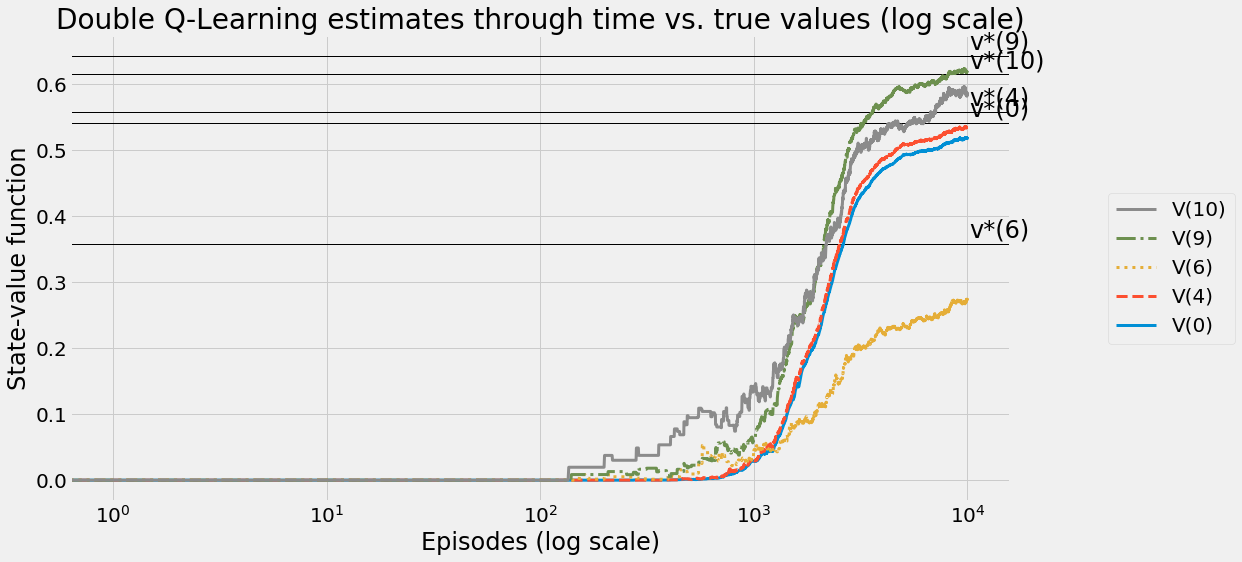

In [106]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_dql, axis=2), 
    optimal_V, 
    limit_items=limit_items,
    limit_value=limit_value,
    log=True)

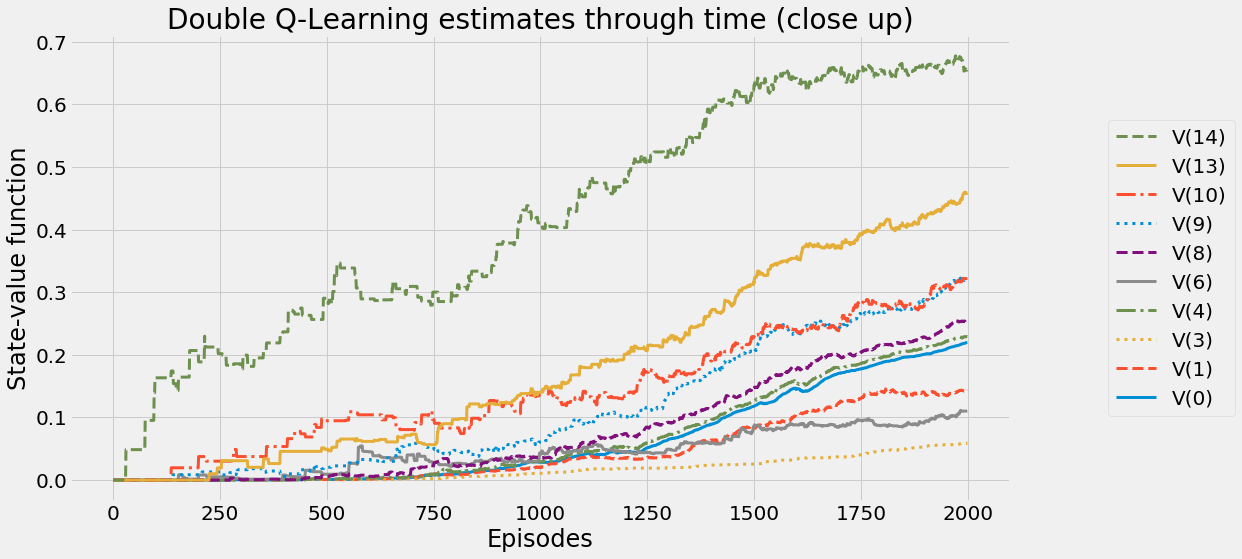

In [107]:
plot_value_function(
    'Double Q-Learning estimates through time (close up)', 
    np.max(Q_track_dql, axis=2)[:cu_episodes], 
    None,
    limit_items=cu_limit_items,
    limit_value=cu_limit_value,
    log=False)

# Policy evolution comparison

In [108]:
mc_success_rate_ma, mc_mean_return_ma, mc_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_mc)

In [109]:
sarsa_success_rate_ma, sarsa_mean_return_ma, sarsa_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_sarsa)

In [110]:
ql_success_rate_ma, ql_mean_return_ma, ql_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_ql)

In [111]:
dql_success_rate_ma, dql_mean_return_ma, dql_mean_regret_ma = get_metrics_from_tracks(
    env, gamma, goal_state, optimal_Q, pi_track_dql)

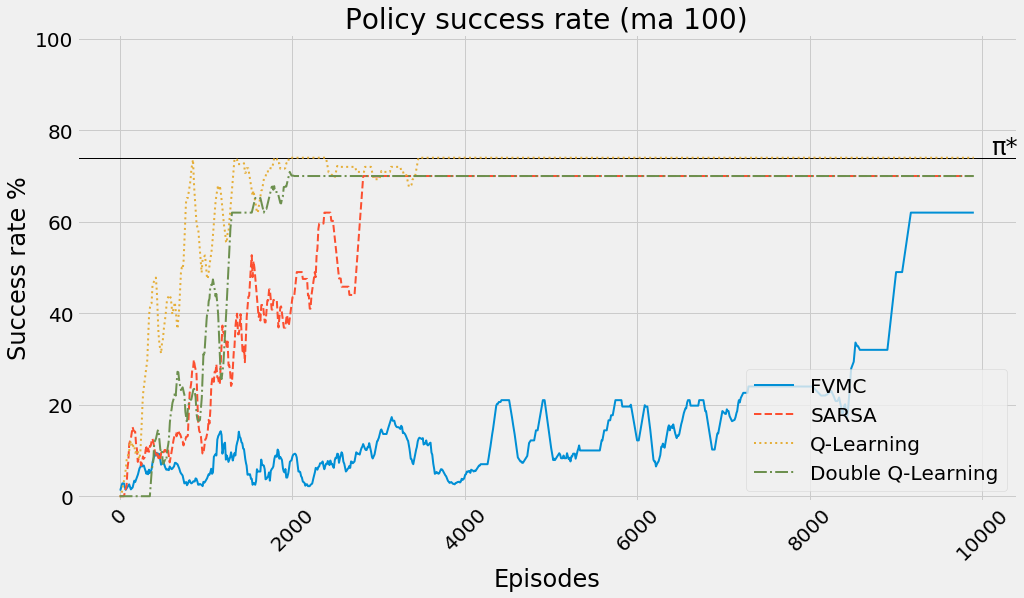

In [112]:
plt.axhline(y=success_rate_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_success_rate_ma)*1.02), success_rate_op*1.01, 'π*')

plt.plot(mc_success_rate_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_success_rate_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_success_rate_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_success_rate_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy success rate (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.ylim(-1, 101)
plt.xticks(rotation=45)

plt.show()

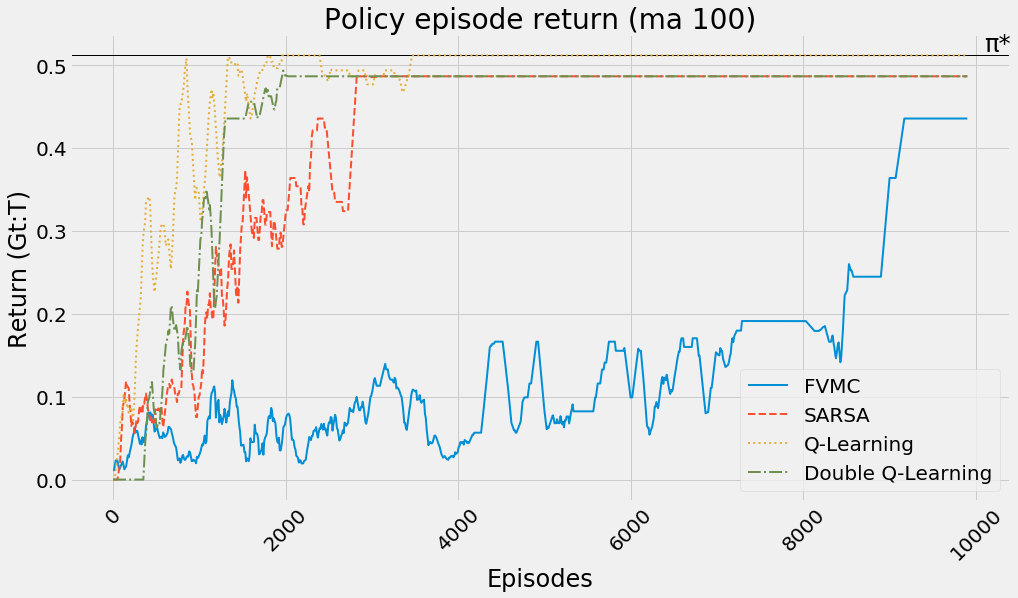

In [113]:
plt.axhline(y=mean_return_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_mean_return_ma)*1.02), mean_return_op*1.01, 'π*')

plt.plot(mc_mean_return_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_return_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_mean_return_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_return_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy episode return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Return (Gt:T)')

plt.xticks(rotation=45)

plt.show()

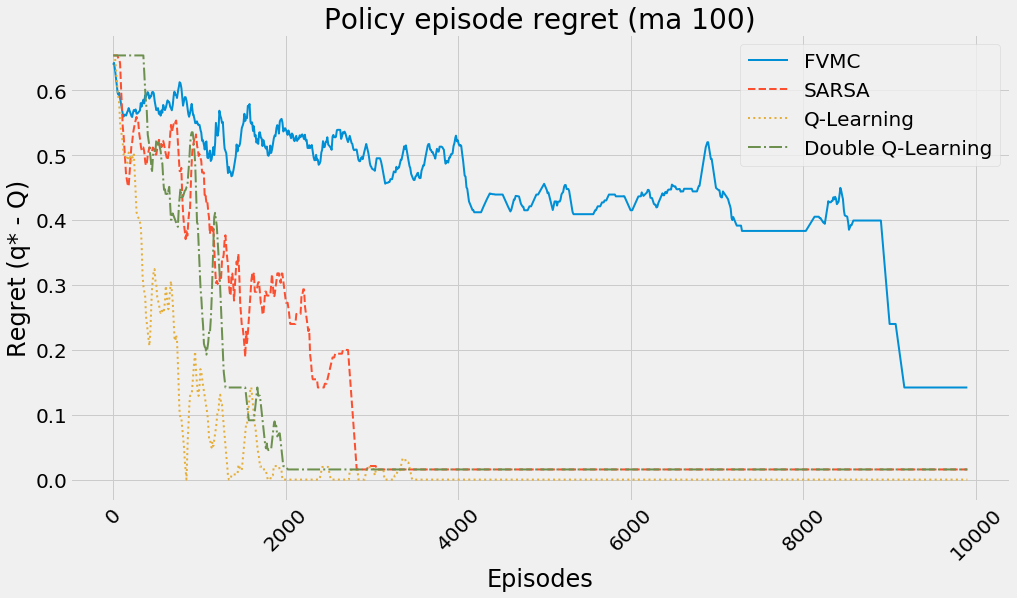

In [114]:
plt.plot(mc_mean_regret_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_regret_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_mean_regret_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_regret_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Policy episode regret (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Regret (q* - Q)')
plt.xticks(rotation=45)

plt.show()

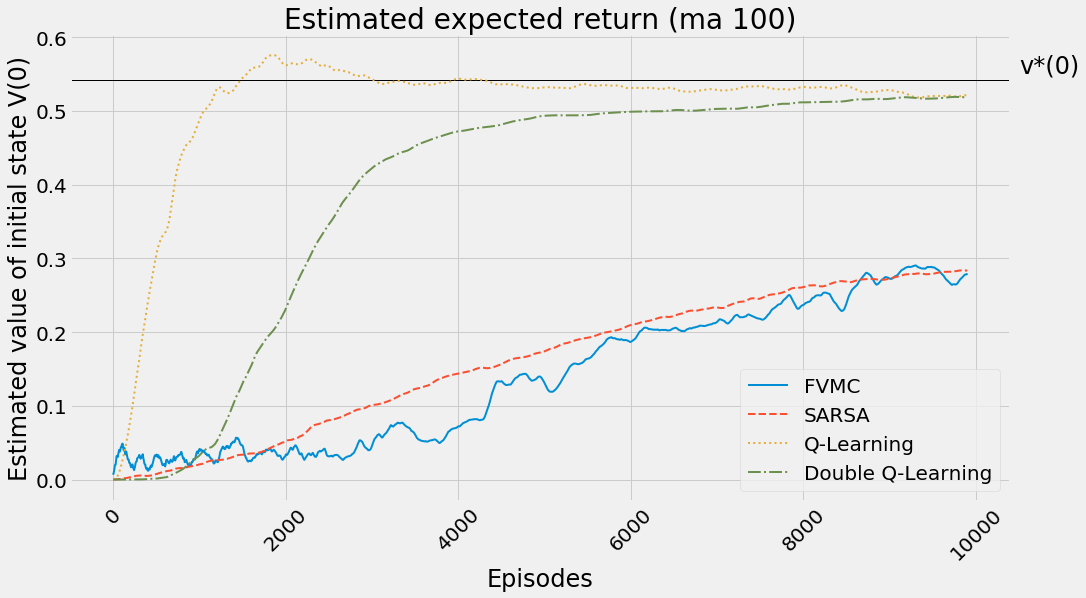

In [115]:
plt.axhline(y=optimal_V[init_state], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_mc)*1.05), optimal_V[init_state]+.01, 'v*({})'.format(init_state))

plt.plot(moving_average(np.max(Q_track_mc, axis=2).T[init_state]), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.max(Q_track_sarsa, axis=2).T[init_state]), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.max(Q_track_ql, axis=2).T[init_state]), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.max(Q_track_dql, axis=2).T[init_state]), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Estimated expected return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state V({})'.format(init_state))
plt.xticks(rotation=45)

plt.show()

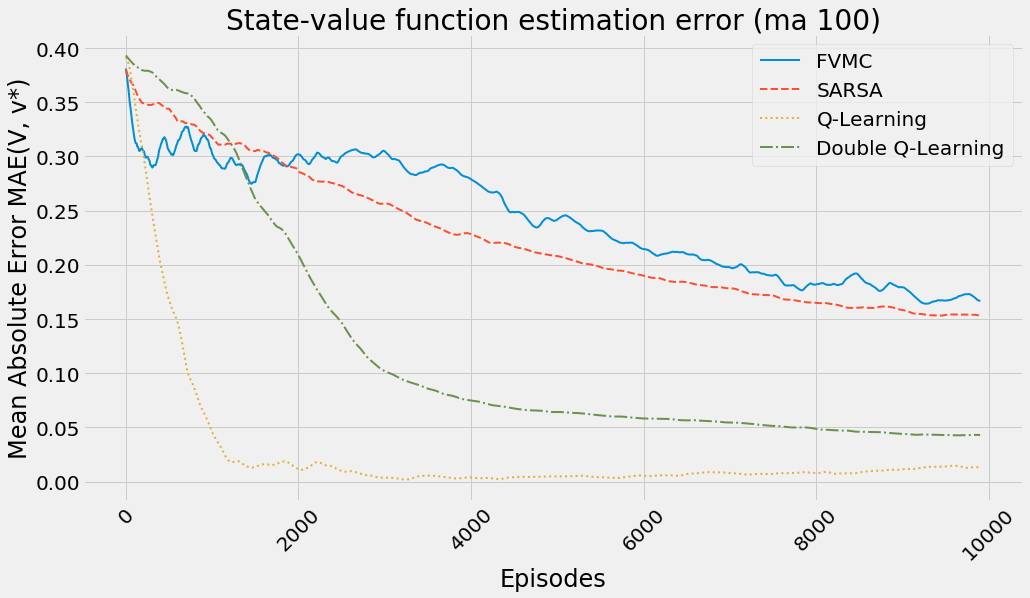

In [116]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_mc, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sarsa, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_ql, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dql, axis=2) - optimal_V), axis=1)), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')
plt.xticks(rotation=45)

plt.show()

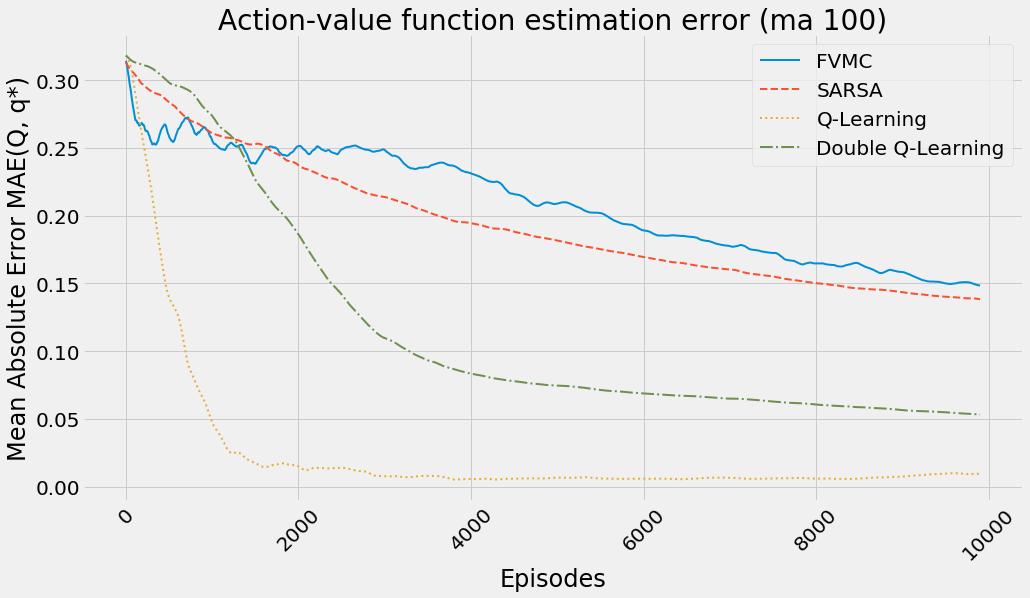

In [117]:
plt.plot(moving_average(np.mean(np.abs(Q_track_mc - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(Q_track_sarsa - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(Q_track_ql - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(Q_track_dql - optimal_Q), axis=(1,2))), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Action-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(Q, q*)')
plt.xticks(rotation=45)

plt.show()